### Creating a dashboard to visualize clustering of cohorts into topics/themes based on the probability of key words being used together. Not removing any duplicates to emphasize the quantity of posts against a particular topic through the bubble size.

In [1]:
import pandas as pd
import gensim
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# Load the data from a CSV file (replace 'data.csv' with your actual file path)
#df = pd.read_csv('/Users/trishitasingh/Downloads/cohortlabels.csv')
df = pd.read_csv('/Users/trishitasingh/Downloads/cohortslabels_updated - 1-2.csv')

In [2]:
df.columns

Index(['client', 'post_date', 'days_on', 'platform', 'post_id', 'post_copy',
       'ad_name', 'link', 'CohortCat', 'cohort', 'asset_type', 'qual_score',
       'followers', 'Impressions', 'comments', 'shares', 'reactions',
       'videoviews', 'saves', 'replies', 'retweets', 'engagements',
       'post_clicks', 'post_link_clicks', 'v_lift'],
      dtype='object')

In [3]:
df = df.rename(columns={'cohort': 'Cohort'})
df = df.rename(columns={'client': 'Client'})
df = df.rename(columns={'v_lift': 'VaynerLift'})

In [4]:
# Select relevant columns for analysis if those values where df['CohortCat'] = ['cohort']
data = df[['Cohort', 'CohortCat']]
data = data[data['CohortCat'] == 'Cohort']

# remove the 'cohortcat' column
data = data.drop('CohortCat', axis=1)

# if the 'cohort' value in column is only used once, remove that row
data = data.groupby('Cohort').filter(lambda x: len(x) > 1)

# Clean and preprocess the text data
def preprocess_text(text):
    processed_text = []
    for token in simple_preprocess(str(text)):  # Convert to string
        if token not in STOPWORDS and len(token) > 3:
            processed_text.append(token)
    return processed_text

data['Cleaned Text'] = data['Cohort'].apply(preprocess_text)

# Create a dictionary representation of the documents
dictionary = gensim.corpora.Dictionary(data['Cleaned Text'])

# Convert the documents to a bag-of-words representation
bow_corpus = [dictionary.doc2bow(doc) for doc in data['Cleaned Text']]

# Train the LDA model (25,50)
num_topics = 15  # Set the desired number of topics
lda_model = gensim.models.LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=50)

# Prepare the data for visualization using pyLDAvis
vis_data = gensimvis.prepare(lda_model, bow_corpus, dictionary)

# Create the interactive visualization
pyLDAvis.display(vis_data)


## Broad Overview: There are 3 dimensions along which all our content is produced (version of visualization keeps refreshing/changes in axis)
1. Top right is very related to parents, kids, girls, boys and the other key words are more contextual to their need/activity/priority
2. Bottom right i think is not very consistent - multiple themes found within each bubble. One prominent theme i believe is women - with huge focus on menstruation and comfort
3. Intersection of both above has topics that are moving to activities to milennials/zillenials but also over reaching topics related to parents as shown. These activities are common across both types of audience groups - ranging to cars, luxury, travel, fitness and shopping
4. Top left has two promient themes - systems/gov/municipalities and fan/sports/coach/seasons

This gives us a general sense of our distribution of content on our posts via cohorts. However, intuiteively we should be able to get something very straight forward. With age groups on different quadrant, overlapping activities on the axis, and specific activities in the centre of each quadrant - ASSUMING OUR IDEAL WAY OF TARGETTING CUSTOMERS FOR MAXIMUM COST EFFICIENCY. 

That is not the case unfortunately. These could be because of few reasons:
1. Mis-distribution of cohorts - we genuinely only focus on these topics prominently and are actively not engaging in other age groups or activities
2. Mis-categorization of cohorts - we are creating content and seeing the results but it has not been correctly categorized to the right cohort
3. Un-standardized practise of cohort nomenclature - we are not using the right keywords to create cohorts, that is not allowing us to see the specificites of what we are targeting

In [5]:
# Count of unique values of cohort
data['Cohort'].nunique()

684

In [6]:
df.columns

Index(['Client', 'post_date', 'days_on', 'platform', 'post_id', 'post_copy',
       'ad_name', 'link', 'CohortCat', 'Cohort', 'asset_type', 'qual_score',
       'followers', 'Impressions', 'comments', 'shares', 'reactions',
       'videoviews', 'saves', 'replies', 'retweets', 'engagements',
       'post_clicks', 'post_link_clicks', 'VaynerLift'],
      dtype='object')

## Filtering the dashboard on a client level

In [7]:
import pandas as pd
import gensim
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# Load the data from a CSV file (replace 'data.csv' with your actual file path)
#df = pd.read_csv('/Users/trishitasingh/Downloads/cohortlabels.csv')

# Select relevant columns for analysis if those values where df['CohortCat'] = 'cohort'
data = df[['Cohort', 'CohortCat', 'Client', 'VaynerLift']]
data = data[data['CohortCat'] == 'Cohort']

# Remove the 'CohortCat' column
data = data.drop('CohortCat', axis=1)

# Clean and preprocess the text data
def preprocess_text(text):
    processed_text = []
    for token in simple_preprocess(str(text)):
        if token not in STOPWORDS and len(token) > 3:
            processed_text.append(token)
    return processed_text

data['Cleaned Text'] = data['Cohort'].apply(preprocess_text)

# Create a dictionary representation of the documents
dictionary = gensim.corpora.Dictionary(data['Cleaned Text'])

# Convert the documents to a bag-of-words representation
bow_corpus = [dictionary.doc2bow(doc) for doc in data['Cleaned Text']]

# Train the LDA model
num_topics = 15
lda_model = gensim.models.LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=50)

# Prepare the data for visualization using pyLDAvis
vis_data = gensimvis.prepare(lda_model, bow_corpus, dictionary)

# Calculate cumulative Vayner Lift score for each topic
topic_vayner_lift = {}
for i, topic in enumerate(lda_model.show_topics(num_topics=num_topics, formatted=False)):
    topic_vayner_lift[i] = df.loc[df['Cohort'].isin(data['Cohort'])]['VaynerLift'].mean()

# Add cumulative Vayner Lift score to visualization data
vis_data.topic_info['VaynerLift'] = vis_data.topic_info['Category'].map(topic_vayner_lift)

# Define a function to update the visualization based on the selected client
def update_visualization(selected_client):
    # Filter the data based on the selected client
    filtered_data = data[data['Client'] == selected_client]

    # Create a dictionary representation of the filtered documents
    filtered_dictionary = gensim.corpora.Dictionary(filtered_data['Cleaned Text'])

    # Convert the filtered documents to a bag-of-words representation
    filtered_bow_corpus = [filtered_dictionary.doc2bow(doc) for doc in filtered_data['Cleaned Text']]

    # Train the LDA model on the filtered data
    filtered_lda_model = gensim.models.LdaModel(filtered_bow_corpus, num_topics=num_topics, id2word=filtered_dictionary, passes=30)

    # Prepare the filtered data for visualization using pyLDAvis
    filtered_vis_data = gensimvis.prepare(filtered_lda_model, filtered_bow_corpus, filtered_dictionary)

    # Calculate cumulative Vayner Lift score for each topic on the filtered data
    filtered_topic_vayner_lift = {}
    for i, topic in enumerate(filtered_lda_model.show_topics(num_topics=num_topics, formatted=False)):
        filtered_topic_vayner_lift[i] = filtered_data['VaynerLift'].mean()

    # Add cumulative Vayner Lift score to filtered visualization data
    filtered_vis_data.topic_info['VaynerLift'] = filtered_vis_data.topic_info['Category'].map(filtered_topic_vayner_lift)

    # Create the updated interactive visualization
    pyLDAvis.display(filtered_vis_data)

# Get the unique values from the 'Client' column
clients = data['Client'].unique()

# Prompt the user for the client filter
print("Available Clients:")
for i, client in enumerate(clients):
    print(f"{i+1}. {client}")

client_selection = input("Select a Client (enter the corresponding number): ")
selected_client = clients[int(client_selection) - 1]

# Update the visualization based on the selected client
update_visualization(selected_client)


Available Clients:
1. Thomas&Friends
2. Alton Towers
3. Duracell
4. EchoPark
5. Fanatics
6. Kimberly Clark
7. St Jude
8. Casper
9. Coach
10. Ford Pro
11. Ticketmaster
12. SharkNinja
13. Zalando
14. Diageo
15. Visa
16. Duolingo
17. Pearson
18. Zoom
19. Flamin Hot
20. Zappos
21. Ford
22. Wander Wheels
23. Wegmans
24. Pico
25. NatWest
26. Durex


In [8]:
# Define a function to update the visualization based on the selected client
def update_visualization(client):
    print("Selected Client:", client)

    # Filter the data based on the selected client
    filtered_data = data[data['Client'] == client]
    print("Filtered Data:")
    print(filtered_data.head())

    # Create a dictionary representation of the filtered documents
    filtered_dictionary = gensim.corpora.Dictionary(filtered_data['Cleaned Text'])
    print("Filtered Dictionary:")
    print(filtered_dictionary)

    # Convert the filtered documents to a bag-of-words representation
    filtered_bow_corpus = [filtered_dictionary.doc2bow(doc) for doc in filtered_data['Cleaned Text']]
    print("Filtered BOW Corpus:")
    print(filtered_bow_corpus[:5])

    # Train the LDA model on the filtered data
    filtered_lda_model = gensim.models.LdaModel(filtered_bow_corpus, num_topics=num_topics, id2word=filtered_dictionary, passes=30)
    print("Filtered LDA Model:")
    print(filtered_lda_model)

    # Prepare the filtered data for visualization using pyLDAvis
    filtered_vis_data = gensimvis.prepare(filtered_lda_model, filtered_bow_corpus, filtered_dictionary)
    print("Filtered Visualization Data:")
    print(filtered_vis_data)

    # Save the interactive visualization as an HTML file
    pyLDAvis.save_html(filtered_vis_data, 'lda_visualization.html')

    # Display a message to indicate the file name and location
    print("Interactive visualization saved as 'lda_visualization.html'")

    # Open the HTML file in the default web browser
    import webbrowser
    webbrowser.open('lda_visualization.html')

# Get the unique values from the 'Client' column
clients = data['Client'].unique()
print("Available Clients:")
for i, client in enumerate(clients):
    print(f"{i+1}. {client}")

client_selection = input("Select a Client (enter the corresponding number): ")
selected_client = clients[int(client_selection) - 1]

# Update the visualization based on the selected client
update_visualization(selected_client)


Available Clients:
1. Thomas&Friends
2. Alton Towers
3. Duracell
4. EchoPark
5. Fanatics
6. Kimberly Clark
7. St Jude
8. Casper
9. Coach
10. Ford Pro
11. Ticketmaster
12. SharkNinja
13. Zalando
14. Diageo
15. Visa
16. Duolingo
17. Pearson
18. Zoom
19. Flamin Hot
20. Zappos
21. Ford
22. Wander Wheels
23. Wegmans
24. Pico
25. NatWest
26. Durex
Selected Client: Duracell
Filtered Data:
                                               Cohort    Client  VaynerLift  \
8   Everyday Underdogs Doing Their Best to Power T...  Duracell        0.17   
9   Seasoned Second Time Parents Curating for Qual...  Duracell        0.30   
10  Everyday Underdogs Doing Their Best to Power T...  Duracell        0.29   
11  Unwavering Underdog Loyalists Committed to the...  Duracell        0.23   
12  Everyday Underdogs Doing Their Best to Power T...  Duracell        0.07   

                                         Cleaned Text  
8            [everyday, underdogs, best, power, life]  
9   [seasoned, second, time,

Assuming the first two reasons for an unstable graph aren't correct, we can prove if there is an issue with the number of keywords/specifity being used when tackling a cohort. This brings us to our question on the value of 'cohorts with teeth' and how the lack of it might or might not impact the performance

To analyze that, we assume = more the keywords in a cohort, more the specificity and we are creating content structurally that is targetting audience groups with the set intention. For eg. Assuming a random high number of keywords - 20, we see below that there is 6% decrease already with cohorts that had lesser keywords. 

In [9]:
# Save the interactive visualization as an HTML file
pyLDAvis.save_html(vis_data, 'lda_visualization.html')

# Display a message to indicate the file name and location
print("Interactive visualization saved as 'lda_visualization.html'")

# Open the HTML file in the default web browser
import os
import webbrowser

# Get the full path of the saved HTML file
html_file_path = os.path.abspath('lda_visualization.html')

# Open the HTML file in the default web browser
webbrowser.open('file://' + html_file_path)


Interactive visualization saved as 'lda_visualization.html'


True

## Analyzing cohorts with teeth

In [10]:
import pandas as pd

# Load the data from a CSV file (replace 'data.csv' with your actual file path)
#df = pd.read_csv('/Users/trishitasingh/Downloads/cohortlabels.csv')

# Select relevant columns for analysis if those values where df['CohortCat'] = 'cohort'
data = df[['Cohort', 'CohortCat', 'VaynerLift']]
data = data[data['CohortCat'] == 'Cohort']

# Remove the 'CohortCat' column
data = data.drop('CohortCat', axis=1)

# Count the number of keywords in each cohort
data['KeywordCount'] = data['Cohort'].str.split().apply(len)
#data.drop_duplicates(subset='Cohort', inplace=True)

# Calculate the average Vayner Lift for cohorts with at least four keywords
avg_vayner_lift_at_least_4_keywords = data[data['KeywordCount'] >= 20]['VaynerLift'].mean()

# Calculate the average Vayner Lift for cohorts with less than four keywords
avg_vayner_lift_less_than_4_keywords = data[data['KeywordCount'] < 20]['VaynerLift'].mean()

# Print the average Vayner Lift for cohorts with at least four keywords and less than four keywords
print("Average Vayner Lift for cohorts with at least four keywords:", avg_vayner_lift_at_least_4_keywords)
print("Average Vayner Lift for cohorts with less than four keywords:", avg_vayner_lift_less_than_4_keywords)


Average Vayner Lift for cohorts with at least four keywords: 0.33591836734693886
Average Vayner Lift for cohorts with less than four keywords: 0.2683897207025626


Specifically, these were the cohorts that led to this higher number. Although they don't completely align with the teeth, it still does provide a lot of context to the cohort. 

In [11]:
cohorts_with_at_least_20_keywords = data[data['KeywordCount'] >= 20]['Cohort'].unique()

# Print the cohorts with at least 20 keywords
for cohort in cohorts_with_at_least_20_keywords:
    print(cohort)

UBK - Menstruators who are living a very active lifestyle and need a pad that is secure & won’t leak.
Parents of 10-15 year olds who are coming to Alton Towers for the first time, but don’t know anything about the resort
15-20 year olds who downright refuse to step foot in a horror maze, but can’t miss out on Halloween celebrations
(Parents of) 4-16 year olds living in Scotland that have broken up for Summer earlier than the rest of the UK
UBK - Menstruators who almost exclusively wear pads (from UbK or competitors) and favor their comfort and feel over tampons.
New Military Parents of Virginia Who Want to Spend As Much Time with Their Child As Possible During K-12 to Make Up For Complex Schedule
Earth Mamas Mindfully Curating Their Family’s Cabinets (NO LONGER IN USE)/American Drive to Survivors In Search of Plotlines Over Points


In [12]:
# Filter cohorts with at least 20 keywords
cohorts_with_at_least_20_keywords = data[data['KeywordCount'] >= 20]['Cohort']

# Print the count of cohorts with at least 20 keywords
count_of_cohorts_with_at_least_20_keywords = len(cohorts_with_at_least_20_keywords)
print("Count of posts with at least 20 keywords:", count_of_cohorts_with_at_least_20_keywords)


Count of posts with at least 20 keywords: 98


We had only 98 posts/17K approx rows with these many keywords - which highlights a huge mis-proportion of volume of posts that are catered to cohorts with teeth. On further analysis, we should look at the average vayner lift for every length of keyword in a cohort to see if this is a trend of mis-proportion of cohorts w/o teeth, and do cohorts with teeth indeed have a higher performance. 

## Average vayner lift mean seems to have an upward trend with higher keywords with some inconsistencies. This could be again because of two reasons:
1. There is indeed no pattern
2. Mis-distribution of volume of posts
3. Performance for those specific cohorts specifically didn't resonate, and hence it was affected due to external reasons

Assuming, there is a pattern, let's look at what's happening for the highest vayner lift keyword cohorts - 16. These are indeed cohorts with teeth - reflecting on generation, activity - not location specific

Let's also look at the volume of posts to see if there is a bias on the dips!

In [13]:
df.columns

Index(['Client', 'post_date', 'days_on', 'platform', 'post_id', 'post_copy',
       'ad_name', 'link', 'CohortCat', 'Cohort', 'asset_type', 'qual_score',
       'followers', 'Impressions', 'comments', 'shares', 'reactions',
       'videoviews', 'saves', 'replies', 'retweets', 'engagements',
       'post_clicks', 'post_link_clicks', 'VaynerLift'],
      dtype='object')

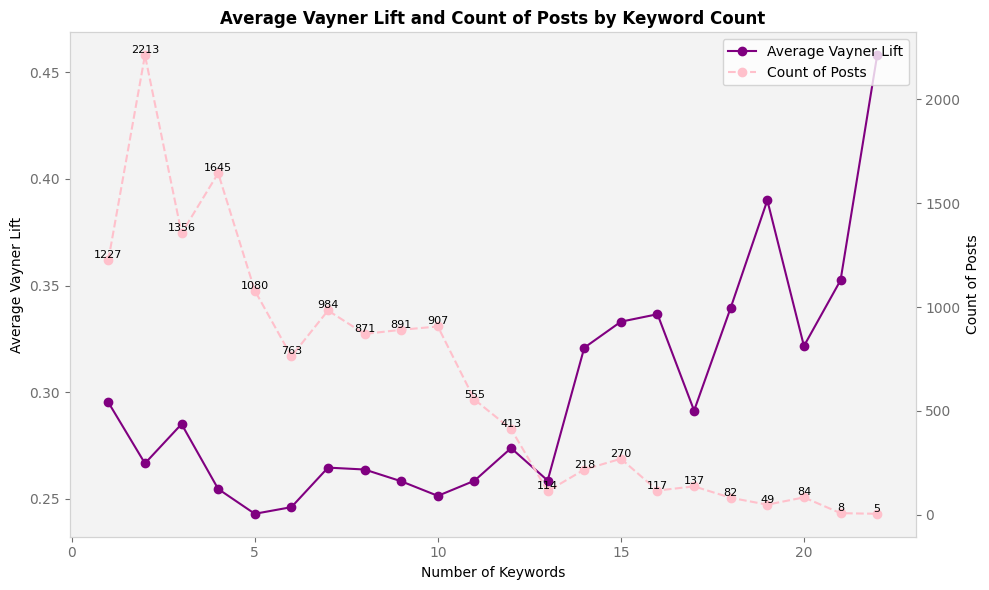

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from a CSV file (replace 'data.csv' with your actual file path)
#df = pd.read_csv('/Users/trishitasingh/Downloads/cohortlabels.csv')

# Select relevant columns for analysis if those values where df['CohortCat'] = 'cohort'
data = df[['Cohort', 'CohortCat', 'VaynerLift']]
data = data[data['CohortCat'] == 'Cohort']

# Remove the 'CohortCat' column
data = data.drop('CohortCat', axis=1)

# Calculate the number of keywords in each cohort
data['KeywordCount'] = data['Cohort'].str.split().apply(len)

# Calculate the average Vayner Lift score and count of cohorts for each keyword length
avg_vayner_lift_by_keyword_count = {}
count_of_cohorts_by_keyword_count = {}
for keyword_count in range(1, 23):
    avg_vayner_lift = data[data['KeywordCount'] == keyword_count]['VaynerLift'].mean()
    count_of_cohorts = data[data['KeywordCount'] == keyword_count]['Cohort'].count()
    avg_vayner_lift_by_keyword_count[keyword_count] = avg_vayner_lift
    count_of_cohorts_by_keyword_count[keyword_count] = count_of_cohorts

# Plot the graph
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(avg_vayner_lift_by_keyword_count.keys(), avg_vayner_lift_by_keyword_count.values(), marker='o', label='Average Vayner Lift', color='purple')
ax1.set_xlabel('Number of Keywords')
ax1.set_ylabel('Average Vayner Lift')
ax1.set_title('Average Vayner Lift and Count of Posts by Keyword Count', fontweight='bold')

ax2 = ax1.twinx()
ax2.plot(count_of_cohorts_by_keyword_count.keys(), count_of_cohorts_by_keyword_count.values(), linestyle='--', color='pink', marker='o', label='Count of Posts')
ax2.set_ylabel('Count of Posts')

# Add labels for count of posts on top of the line graph
for x, y in zip(count_of_cohorts_by_keyword_count.keys(), count_of_cohorts_by_keyword_count.values()):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=8)

# Move the legend to the top right
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Adjust the layout and spacing
plt.tight_layout()

# Set pastel shades for the plot
ax1.set_facecolor('#F3F3F3')
ax1.spines['bottom'].set_color('#D3D3D3')
ax1.spines['top'].set_color('#D3D3D3')
ax1.spines['right'].set_color('#D3D3D3')
ax1.spines['left'].set_color('#D3D3D3')
ax1.tick_params(axis='x', colors='#6E6E6E')
ax1.tick_params(axis='y', colors='#6E6E6E')

ax2.spines['bottom'].set_color('#D3D3D3')
ax2.spines['top'].set_color('#D3D3D3')
ax2.spines['right'].set_color('#D3D3D3')
ax2.spines['left'].set_color('#D3D3D3')
ax2.tick_params(axis='y', colors='#6E6E6E')

plt.show()

# Dips for higher keywords - 13 and 17

There indeed is! We are creating almost 20-30% of posts against cohorts with 2-4 keywords, which intuitively wouldn't give alot of content. These comparatively have lesser vayner lift mean - not resonating with our audience as much as we could. 

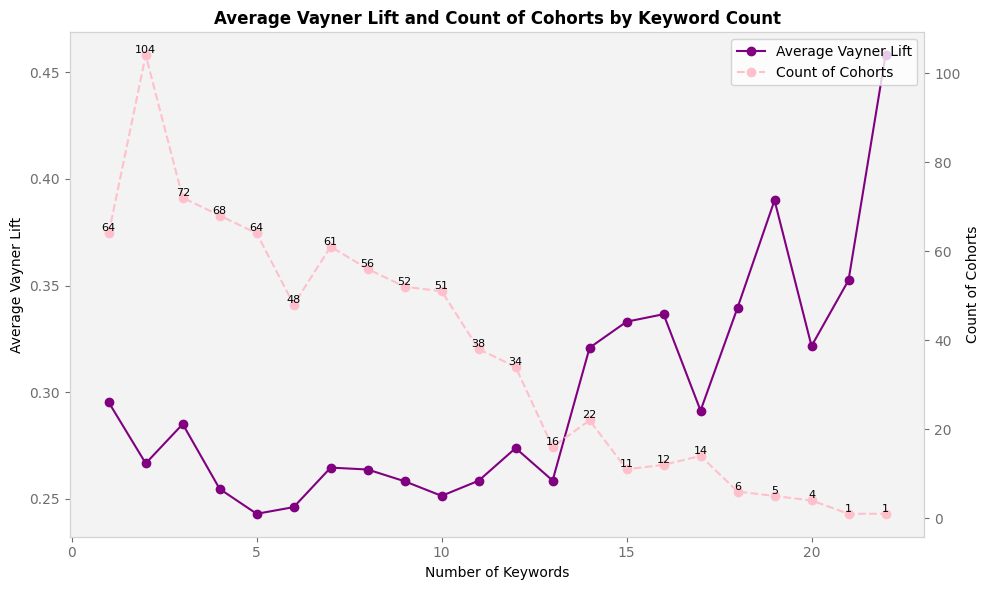

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from a CSV file (replace 'data.csv' with your actual file path)
#df = pd.read_csv('/Users/trishitasingh/Downloads/cohortlabels.csv')

# Select relevant columns for analysis if those values where df['CohortCat'] = 'cohort'
data = df[['Cohort', 'CohortCat', 'VaynerLift']]
data = data[data['CohortCat'] == 'Cohort']

# Remove the 'CohortCat' column
data = data.drop('CohortCat', axis=1)

# Calculate the number of keywords in each cohort
data['KeywordCount'] = data['Cohort'].str.split().apply(len)

# Calculate the average Vayner Lift score and count of cohorts for each keyword length
avg_vayner_lift_by_keyword_count = {}
count_of_cohorts_by_keyword_count = {}
for keyword_count in range(1, 23):
    avg_vayner_lift = data[data['KeywordCount'] == keyword_count]['VaynerLift'].mean()
    count_of_cohorts = data[data['KeywordCount'] == keyword_count]['Cohort'].nunique()
    avg_vayner_lift_by_keyword_count[keyword_count] = avg_vayner_lift
    count_of_cohorts_by_keyword_count[keyword_count] = count_of_cohorts

# Plot the graph
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(avg_vayner_lift_by_keyword_count.keys(), avg_vayner_lift_by_keyword_count.values(), marker='o', label='Average Vayner Lift', color='purple')
ax1.set_xlabel('Number of Keywords')
ax1.set_ylabel('Average Vayner Lift')
ax1.set_title('Average Vayner Lift and Count of Cohorts by Keyword Count', fontweight='bold')

ax2 = ax1.twinx()
ax2.plot(count_of_cohorts_by_keyword_count.keys(), count_of_cohorts_by_keyword_count.values(), linestyle='--', color='pink', marker='o', label='Count of Cohorts')
ax2.set_ylabel('Count of Cohorts')

# Add labels for count of posts on top of the line graph
for x, y in zip(count_of_cohorts_by_keyword_count.keys(), count_of_cohorts_by_keyword_count.values()):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=8)

# Move the legend to the top right
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Adjust the layout and spacing
plt.tight_layout()

# Set pastel shades for the plot
ax1.set_facecolor('#F3F3F3')
ax1.spines['bottom'].set_color('#D3D3D3')
ax1.spines['top'].set_color('#D3D3D3')
ax1.spines['right'].set_color('#D3D3D3')
ax1.spines['left'].set_color('#D3D3D3')
ax1.tick_params(axis='x', colors='#6E6E6E')
ax1.tick_params(axis='y', colors='#6E6E6E')

ax2.spines['bottom'].set_color('#D3D3D3')
ax2.spines['top'].set_color('#D3D3D3')
ax2.spines['right'].set_color('#D3D3D3')
ax2.spines['left'].set_color('#D3D3D3')
ax2.tick_params(axis='y', colors='#6E6E6E')

plt.show()

# Dips for higher keywords - 13 and 17


Similarly holds true for unique cohorts. We are creating a huge chunk of cohorts with 2-4 keywords, which intuitively wouldn't give alot of content. Our cohorts for keywords greater than 12 range only between 0-14. This explains the bias of the dips, affirms the mis-distribution of posts, and shows the potential of high-performance from cohorts with teeth for the few cohorts/posts that have launched. 

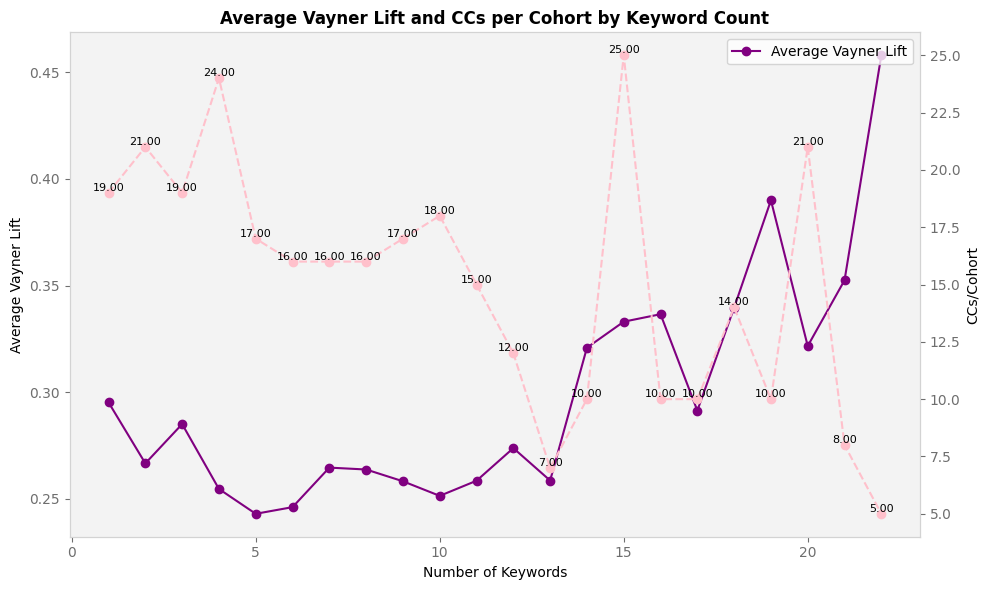

In [16]:
# Calculate the count of posts per unique cohort for each keyword length
posts_per_cohort = {}
for keyword_count in range(1, 23):
    total_posts = data[data['KeywordCount'] == keyword_count]['Cohort'].count()
    unique_cohorts = data[data['KeywordCount'] == keyword_count]['Cohort'].nunique()
    if unique_cohorts != 0:
        posts_per_cohort[keyword_count] = (total_posts / unique_cohorts).round(0)
    else:
        posts_per_cohort[keyword_count] = 0

# Plot the graph
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(avg_vayner_lift_by_keyword_count.keys(), avg_vayner_lift_by_keyword_count.values(), marker='o', label='Average Vayner Lift', color='purple')
ax1.set_xlabel('Number of Keywords')
ax1.set_ylabel('Average Vayner Lift')
ax1.set_title('Average Vayner Lift and CCs per Cohort by Keyword Count', fontweight='bold')

ax2 = ax1.twinx()
ax2.plot(posts_per_cohort.keys(), posts_per_cohort.values(), linestyle='--', color='pink', marker='o')
ax2.set_ylabel('CCs/Cohort')

# Add labels for posts per cohort on top of the line graph
for x, y in zip(posts_per_cohort.keys(), posts_per_cohort.values()):
    plt.text(x, y, f"{y:.2f}", ha='center', va='bottom', fontsize=8)

# Move the legend to the top right
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Adjust the layout and spacing
plt.tight_layout()

# Set pastel shades for the plot
ax1.set_facecolor('#F3F3F3')
ax1.spines['bottom'].set_color('#D3D3D3')
ax1.spines['top'].set_color('#D3D3D3')
ax1.spines['right'].set_color('#D3D3D3')
ax1.spines['left'].set_color('#D3D3D3')
ax1.tick_params(axis='x', colors='#6E6E6E')
ax1.tick_params(axis='y', colors='#6E6E6E')

ax2.spines['bottom'].set_color('#D3D3D3')
ax2.spines['top'].set_color('#D3D3D3')
ax2.spines['right'].set_color('#D3D3D3')
ax2.spines['left'].set_color('#D3D3D3')
ax2.tick_params(axis='y', colors='#6E6E6E')

plt.show()


### Analysis of posts that had dips

In [17]:
# Filter the DataFrame for cohorts with 15 keywords
cohort_15_keywords = data[data['Cohort'].fillna('').str.split().apply(len) == 15]

# Get the unique 'client' values for the filtered cohorts
clients = cohort_15_keywords['Cohort'].unique()

# Print the 'client' values
for client in clients:
    print(client)


UBK - Menstruators who are proud of their periods rather than being ashamed or embarrassed
Individualists Who Need To Insert Their Personal Flair on Items To Make Them Their Own
Coach Diehards Who Know That Trends Come And Go, But Coach Always Will Be Iconic
SMB Owners In Their Early Thirties Taking Over Vacant Storefronts With Their Brick And Mortars
40 y/o+ Parents Living in the Pacific NW Looking For New Ways to Do Good
Tweeting enthusiasts who track their cred count religiously and show it off in their bio
UBK - Womxn who love wandering the aisles of Target or Walmart for secret gems.
Exes from 13-24 yo, that gave up on us due to their hunger for immediacy.
18-26 year old super planners who organise all their trips down to the smallest details
Night owls that live for the adrenaline of doing a lesson 5 minutes before midnight.
Handy Parents Who Pride Themselves on Being Able to Fix Anything (NO LONGER IN USE)


In [18]:
# Filter the DataFrame for cohorts with 13 keywords
cohort_20_keywords = data[data['Cohort'].fillna('').str.split().apply(len) == 20]

# Get the unique 'client' values for the filtered cohorts
clients = cohort_20_keywords['Cohort'].unique()

# Print the 'client' values
for client in clients:
    print(client)

UBK - Menstruators who are living a very active lifestyle and need a pad that is secure & won’t leak.
15-20 year olds who downright refuse to step foot in a horror maze, but can’t miss out on Halloween celebrations
UBK - Menstruators who almost exclusively wear pads (from UbK or competitors) and favor their comfort and feel over tampons.
Earth Mamas Mindfully Curating Their Family’s Cabinets (NO LONGER IN USE)/American Drive to Survivors In Search of Plotlines Over Points


In [19]:
# Filter the DataFrame for cohorts with 18 keywords
cohort_18_keywords = data[data['Cohort'].fillna('').str.split().apply(len) == 18]

# Get the unique 'client' values for the filtered cohorts
clients = cohort_18_keywords['Cohort'].unique()

# Print the 'client' values
for client in clients:
    print(client)

The Smiler fanatics who eat, sleep and breathe the ride (and probably listen to the soundtrack on repeat)
Horror fans who don’t feel one month is enough to celebrate Halloween - for them, it’s a lifestyle
UBK - Menstruators who haven’t found products that work for them, but are tired of trial & error
30-year-olds looking to rekindle the fun they fear they’ve lost in the transition to being a ‘proper adult’
Young Shoppers Who Don’t Know Much About Sustainability But Want To Feel Good About Their Purchases All Around
“My Child is an Angel” Parents Who Celebrate their Child’s Individuality, But Worry About Bullies Making Them Conform


### Analysis of cohorts with 2 keywords - cohorts without teeth

In [20]:
# Filter the DataFrame for cohorts with 2 keywords
cohort_2_keywords = data[data['Cohort'].fillna('').str.split().apply(len) == 2]

# Get the unique 'client' values for the filtered cohorts
clients = cohort_2_keywords['Cohort'].unique()

# Print the 'client' values
for client in clients:
    print(client)

Fleet Managers
Casper Team
General Signals
Low-Key Creatives
Self-Care Queens
Perpetual Browsers
Salon-to-DIY Converts
Inclusivity Advocates
Van Lifers
Functional Fashionistas
Government Municipalities
Healthcare Advocates
Small Businesses
Nostalgia Seekers
Wannabe MUAs
Whatever's Comfortable
Dust Bags
MULTI APPERS
Mess Makers
NEWBIE WINGERS
Insight Mining
Sustainable Shoppers
Memphis Empaths
Inexperienced Enthusiasts
Relatable Runners
Trend Hunters
Hope Core
Neighborhood Uncle
Empty Nesters
Holiday Enthusiasts
Ford Ride-Or-Dies
Recreational Roadtrippers
Adventurous Family
Spicy Streamers
Mini bottle
Daily Diamond
Mother's Day
Bodega Baddies
Canned Cocktail
Anti-Techbro Techies
Mustang Gamers
Local Landscaper
Science Nerds
The Introvert
Houston Rodeo
(Re)charged Up
Indy Gamers
Serious RPGs
Reading Outside
Pedro trend
Adaptive Shoppers
Fitness Conscious
Experience Seekers
Awards Show
Southern Comfort
Zombie Diehards
TV Series
Fitness Enthusiasts
Older Millennials
Wild card
Perpetual Bro

In [21]:
# 1. we need to validate that wild cards are popular and they don't/do outperform, wild card vs vayner lift mean. change the right-y axis to comments and impressions pcs score - index
# 2. how many cc volume to a cohort is the ideal number for optimal performance - cohort saturation
# 3. word count performance dependending on the post text length - word count vs vayner lift mean
# 4. frequent keywords with performance 
# 5. avg number of cc/cohort
# 6. post date of the second cc against the same cohort - that is when the cohort starts. make a performance graph on a brand level. cohorts with 2 ccs/3ccs/5ccs - bins
# 7. cohorts on x-axis; how many ccs/week based on dates

In [22]:
data.shape

(13990, 3)

In [23]:
# Calculate the total number of rows in data (only cohorts) - excluding the wildcard rows/ other/ client ask
total_rows = len(data)

# Calculate the number of unique values in the 'Cohort' column
unique_cohorts = data['Cohort'].nunique()

# Divide total number of rows by the number of unique values
result = total_rows / unique_cohorts
print(result)


17.37888198757764


In [24]:
## wildcard data score
import numpy as np

# Make wildcard_df as a subset dataframe with only wildcard cohorts
wildcard_df = df[df['CohortCat'] == 'Wildcard']

# Calculate the mean of the 'VaynerLift' column to get the VaynerLift mean
vaynerlift_mean = wildcard_df['VaynerLift'].mean()

# Calculate the 'pcs score' for each row
wildcard_df['pcs score'] = wildcard_df['comments'] / wildcard_df['engagements']
wildcard_df['share score'] = wildcard_df['retweets'] / wildcard_df['engagements']

# Print the results
print("Mean PCS Score for non Wildcard rows:", wildcard_df['pcs score'].mean())
print("Mean Share Score for non Wildcard rows:", wildcard_df['share score'].mean())
print("VaynerLift Mean:", vaynerlift_mean)

# Non wild cards had a higher vaynerlift mean due to having higher number of shares despite lesser number of comments

Mean PCS Score for non Wildcard rows: 0.07674833211589148
Mean Share Score for non Wildcard rows: inf
VaynerLift Mean: 0.25123993558776164


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1099294167.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildcard_df['pcs score'] = wildcard_df['comments'] / wildcard_df['engagements']
/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1099294167.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildcard_df['share score'] = wildcard_df['retweets'] / wildcard_df['engagements']


In [25]:
# Unique cohorts in the 'wildcard' category
unique_cohorts = wildcard_df['Cohort'].unique()
unique_cohorts

array(['Wildcard', 'UBK - Wildcard', 'SCOTT - Wildcard',
       'Wildcard Holiday'], dtype=object)

In [26]:
# Subset the DataFrame to include only 'Wildcard' rows
not_wildcard_df = df[df['CohortCat'] != 'Wildcard']

# Calculate the mean of the 'VaynerLift' column to get the VaynerLift mean
vaynerlift_mean = not_wildcard_df['VaynerLift'].mean()

# Calculate the 'pcs score' for each row
not_wildcard_df['pcs score'] = not_wildcard_df['comments'] / not_wildcard_df['engagements']
not_wildcard_df['share score'] = not_wildcard_df['retweets'] / not_wildcard_df['engagements']

# Print the results
print("Mean PCS Score for non Wildcard rows:", not_wildcard_df['pcs score'].mean())
print("Mean Share Score for non Wildcard rows:", not_wildcard_df['share score'].mean())
print("VaynerLift Mean:", vaynerlift_mean)

# Non wild cards had a higher vaynerlift mean due to having higher number of shares despite lesser number of comments

Mean PCS Score for non Wildcard rows: 0.0633367739923711
Mean Share Score for non Wildcard rows: inf
VaynerLift Mean: 0.26836541847634693


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3923709952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_wildcard_df['pcs score'] = not_wildcard_df['comments'] / not_wildcard_df['engagements']
/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3923709952.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_wildcard_df['share score'] = not_wildcard_df['retweets'] / not_wildcard_df['engagements']


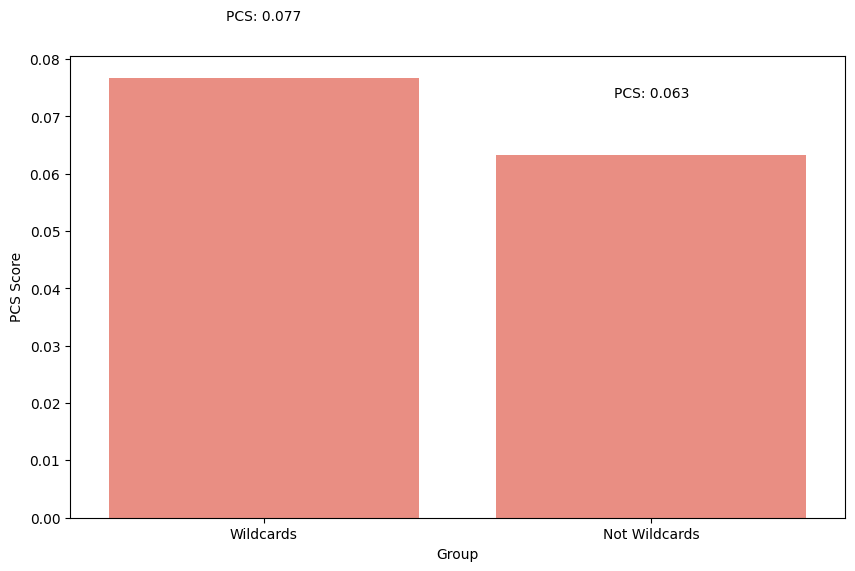

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
data = {
    'Group': ['Wildcards', 'Not Wildcards'],
    'PCS Score': [wildcard_df['pcs score'].mean(), not_wildcard_df['pcs score'].mean()],
}
plot_df = pd.DataFrame(data)

# Create the figure and axes objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot PCS Scores as a bar plot
sns.barplot(x='Group', y='PCS Score', data=plot_df, ax=ax1, color='salmon')

# Set y-axis labels
ax1.set_ylabel('PCS Score')

# Add data point labels
for i, v in enumerate(plot_df['PCS Score']):
    ax1.text(i, v + 0.01, f"PCS: {round(v, 3)}", color='black', ha='center')


plt.show()


In [28]:
# how many cohorts in wild card
# data summary - total size, how many ccs/cohort, breakout - cohort/wildcard/nt/na unique count
# day range of cohorts
# list of clients - each client has how many cohorts/ how many wild card etc
# how many wild cards in each client

# lets call a group - ALL/ N/A / NT
# not_wildcard_df - shouldn't involve vague or broader cohorts like above

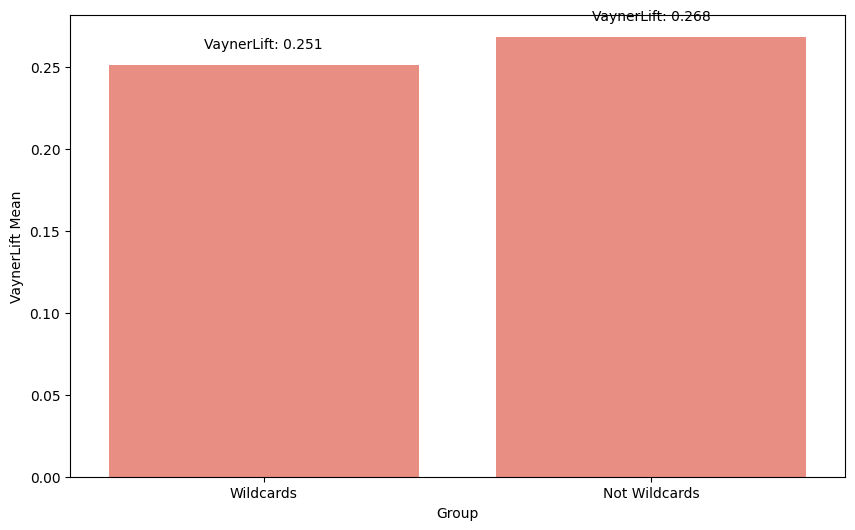

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
data = {
    'Group': ['Wildcards', 'Not Wildcards'],
    'VaynerLift': [wildcard_df['VaynerLift'].mean(), not_wildcard_df['VaynerLift'].mean()],
}
plot_df = pd.DataFrame(data)

# Create the figure and axes objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot PCS Scores as a bar plot
sns.barplot(x='Group', y='VaynerLift', data=plot_df, ax=ax1, color='salmon')

# Set y-axis labels
ax1.set_ylabel('VaynerLift Mean')

# Add data point labels
for i, v in enumerate(plot_df['VaynerLift']):
    ax1.text(i, v + 0.01, f"VaynerLift: {round(v, 3)}", color='black', ha='center')


plt.show()


Frequency of each Word Count group:
1     1227
2     2213
3     1356
4     1645
5     1080
6      763
7      984
8      871
9      891
10     907
11     555
12     413
13     114
14     218
15     270
16     117
17     137
18      82
19      49
20      84
21       8
22       5
25       1
Name: Word Count, dtype: int64


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3705466653.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Word Count'] = data['Cohort'].apply(lambda x: len(str(x).split()))


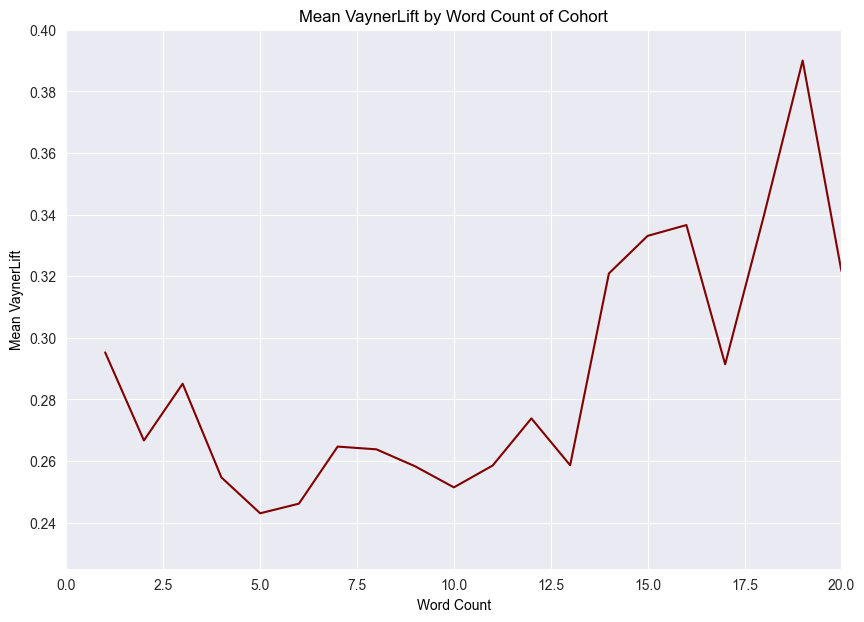

In [30]:
# 2. word count of creative and mean vayner lift - this includes wildcards/ no cohorts

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Step 1: Calculate word count for each 'Cohort'
data = df[df['CohortCat'] == 'Cohort']
data['Word Count'] = data['Cohort'].apply(lambda x: len(str(x).split()))

# Step 2: Calculate the mean VaynerLift for each word count
grouped_vaynerlift_means = data.groupby('Word Count')['VaynerLift'].mean()

# Step 3: Calculate the frequency of each word count group
grouped_word_counts = data['Word Count'].value_counts().sort_index()

# Create the plot with increased size
plt.figure(figsize=(10, 7))

# Set background color to gray
sns.set_style("darkgrid")

# Plot data with maroon line
sns.lineplot(x=grouped_vaynerlift_means.index, y=grouped_vaynerlift_means.values, color='maroon')

# Add labels and title with black color
plt.xlabel('Word Count', color='black')
plt.ylabel('Mean VaynerLift', color='black')
plt.title('Mean VaynerLift by Word Count of Cohort', color='black')
plt.xlim(0,20)
plt.ylim(0.225,0.40)

#for x, y in zip(grouped_vaynerlift_means.index, grouped_vaynerlift_means.values):
   # plt.text(x, y + 0.025, str(grouped_word_counts[x]), color='black')

# Print the frequency of each word count group
print("Frequency of each Word Count group:")
print(grouped_word_counts)

# Show the plot
plt.show()


In [31]:
grouped_vaynerlift_means

Word Count
1     0.295240
2     0.266643
3     0.285066
4     0.254644
5     0.243000
6     0.246121
7     0.264654
8     0.263766
9     0.258249
10    0.251411
11    0.258505
12    0.273801
13    0.258596
14    0.320872
15    0.333074
16    0.336581
17    0.291387
18    0.339634
19    0.390000
20    0.321667
21    0.352500
22    0.458000
25    0.790000
Name: VaynerLift, dtype: float64

In [32]:
# Outlier with one data point and highest Vayner lift (not plotted on the graph)
word_count_25_df = data[data['Word Count'] == 25]['Cohort'].unique()
print(word_count_25_df)

['New Military Parents of Virginia Who Want to Spend As Much Time with Their Child As Possible During K-12 to Make Up For Complex Schedule']


In [33]:
# 3. frequent keywords and vayner lift mean

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import string
from collections import Counter
from nltk.corpus import stopwords


keyword_df = data

# Adding 'their' and 'THEIR' to the stop words set
stop_words = set(stopwords.words('english'))
stop_words.update(['Their', 'THEIR'])



<>:5: DeprecationWarning: invalid escape sequence '\w'
<>:8: DeprecationWarning: invalid escape sequence '\d'
<>:5: DeprecationWarning: invalid escape sequence '\w'
<>:8: DeprecationWarning: invalid escape sequence '\d'
/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1043025518.py:5: DeprecationWarning: invalid escape sequence '\w'
  keyword_df['Cleaned Cohort'] = keyword_df['Cleaned Cohort'].str.replace('[^\w\s]', '')
/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1043025518.py:8: DeprecationWarning: invalid escape sequence '\d'
  keyword_df['Cleaned Cohort'] = keyword_df['Cleaned Cohort'].str.replace('\d+', '')
/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1043025518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

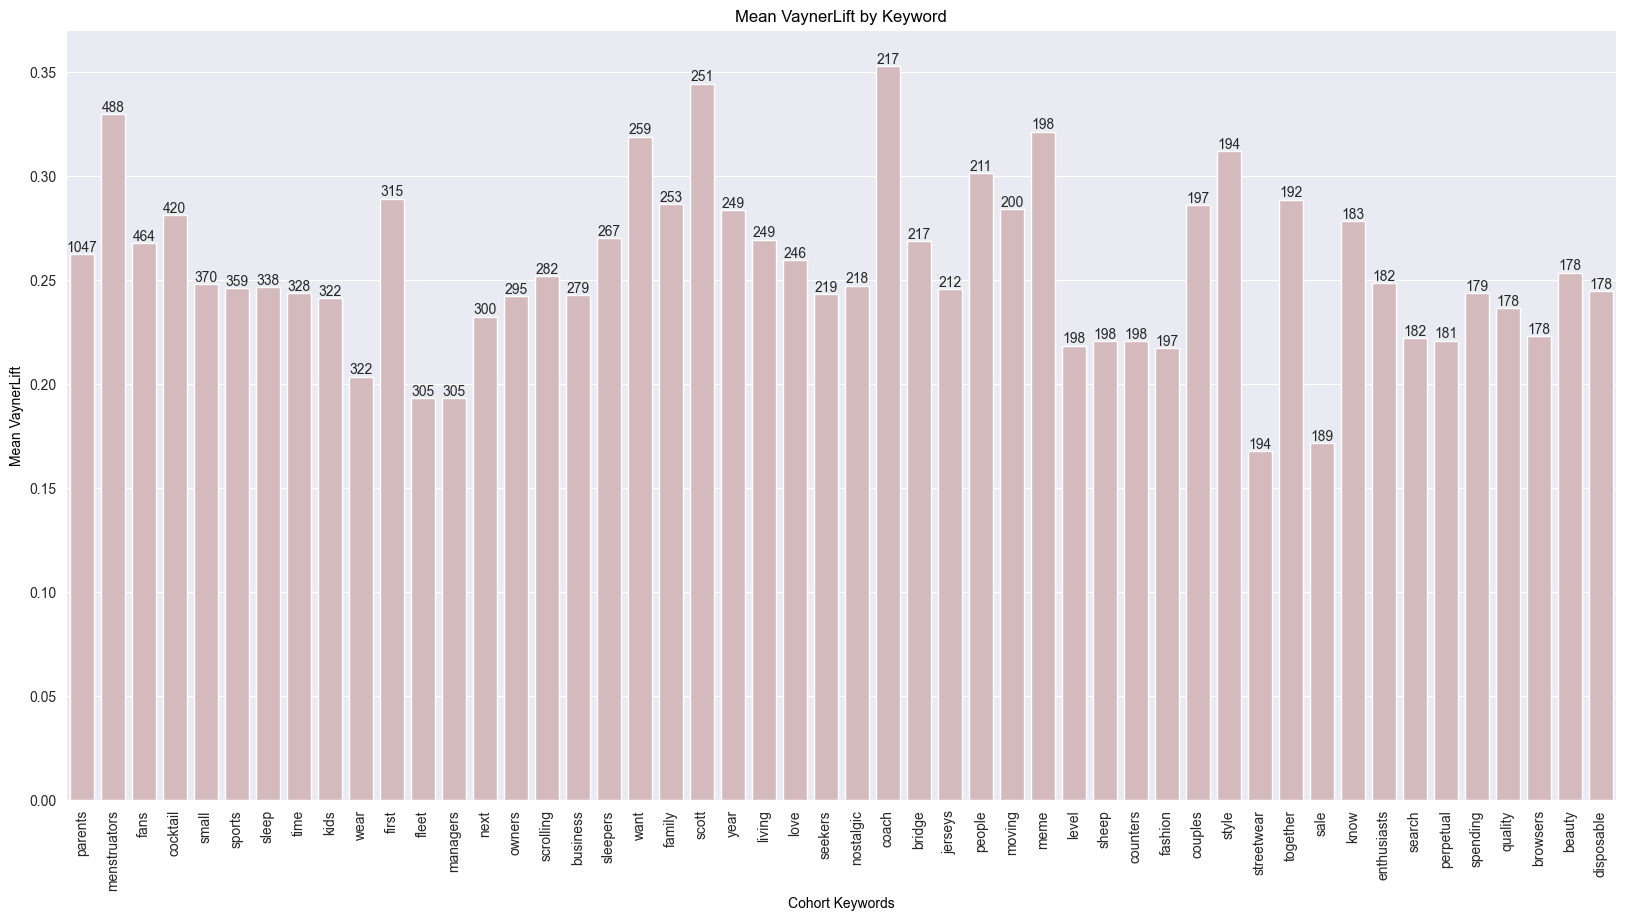

In [34]:
# Convert to lowercase first
keyword_df['Cleaned Cohort'] = keyword_df['Cohort'].str.lower()

# Remove punctuation
keyword_df['Cleaned Cohort'] = keyword_df['Cleaned Cohort'].str.replace('[^\w\s]', '') 

# Remove numbers
keyword_df['Cleaned Cohort'] = keyword_df['Cleaned Cohort'].str.replace('\d+', '')  

# Define stop words 
stop_words = set(stopwords.words('english'))

# Remove stop words
keyword_df['Cleaned Cohort'] = keyword_df['Cleaned Cohort'].apply(lambda x: ' '.join(word for word in str(x).split() if word not in stop_words))


# Tokenize the cleaned text and count the frequency of each word
words = keyword_df['Cleaned Cohort'].str.split(expand=True).stack()
word_counts = Counter(words)

# Filter out words that are less than 4 letters long
filtered_word_counts = {word: count for word, count in word_counts.items() if word not in stop_words and len(word) >= 4}

# Get the top 50 most frequent words
top_50_words = dict(sorted(filtered_word_counts.items(), key=lambda item: item[1], reverse=True)[:50])

# Step 2: For each keyword, find the rows in which the 'Cleaned Cohort' contains this keyword and calculate the mean VaynerLift score
keyword_vaynerlift_means = []
for word in top_50_words.keys():
    vaynerlift_mean = keyword_df[keyword_df['Cleaned Cohort'].str.contains(word, case=False, na=False)]['VaynerLift'].mean()
    keyword_vaynerlift_means.append(vaynerlift_mean)
    

# Create the plot with increased size
plt.figure(figsize=(20, 10))

# Set background color to gray
sns.set_style("darkgrid")

# Create bar plot
barplot = sns.barplot(x=list(top_50_words.keys()), y=keyword_vaynerlift_means, color='#D8B6B9')

# Add labels and title with black color
plt.xlabel('Cohort Keywords', color='black')
plt.ylabel('Mean VaynerLift', color='black')
plt.title('Mean VaynerLift by Keyword', color='black')

# Rotate x-axis labels 45 degrees
plt.xticks(rotation=90)

# Add frequency count labels to each bar
for i, word in enumerate(top_50_words.keys()):
    plt.text(i, keyword_vaynerlift_means[i], top_50_words[word], ha='center', va='bottom')

# Show the plot
plt.show()


<>:20: DeprecationWarning: invalid escape sequence '\w'
<>:23: DeprecationWarning: invalid escape sequence '\d'
<>:20: DeprecationWarning: invalid escape sequence '\w'
<>:23: DeprecationWarning: invalid escape sequence '\d'
/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1563510090.py:20: DeprecationWarning: invalid escape sequence '\w'
  filtered_df['Cleaned Cohort'] = filtered_df['Cleaned Cohort'].str.replace('[^\w\s]', '')
/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1563510090.py:23: DeprecationWarning: invalid escape sequence '\d'
  filtered_df['Cleaned Cohort'] = filtered_df['Cleaned Cohort'].str.replace('\d+', '')
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/trishitasingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/trishitasingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/9s/38yb0xn536968pgvsk_rgxj400

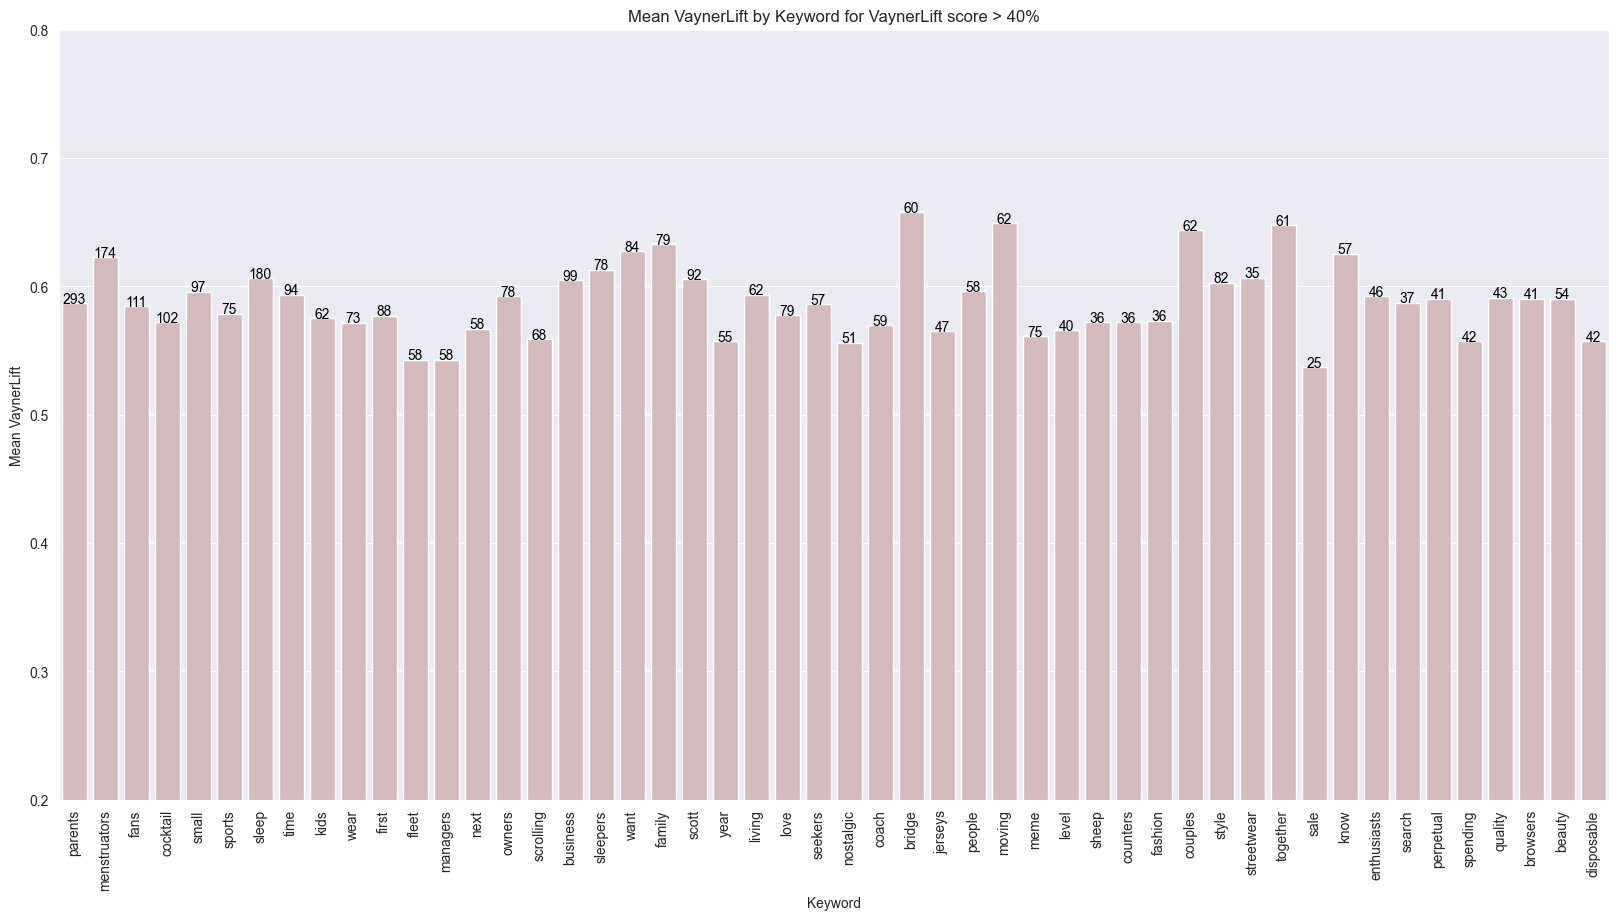

In [35]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download('stopwords')

# Filter the DataFrame to include only rows with a VaynerLift score above 40%
filtered_df = keyword_df[keyword_df['VaynerLift'] > 0.4]

# Convert to lowercase first
filtered_df['Cleaned Cohort'] = filtered_df['Cohort'].str.lower()

# Remove punctuation
filtered_df['Cleaned Cohort'] = filtered_df['Cleaned Cohort'].str.replace('[^\w\s]', '') 

# Remove numbers
filtered_df['Cleaned Cohort'] = filtered_df['Cleaned Cohort'].str.replace('\d+', '')  

# Define stop words 
stop_words = set(stopwords.words('english'))

# Remove stop words
filtered_df['Cleaned Cohort'] = filtered_df['Cleaned Cohort'].apply(lambda x: ' '.join(word for word in str(x).split() if word not in stop_words))


# Remove stopwords and words less than 4 letters long
stop_words = set(stopwords.words('english'))
words = [word for word in words if word not in stop_words and len(word) >= 4]

# Count the frequency of each word
word_freq = Counter(words)

# Get the top 100 most common words
top_100_words = word_freq.most_common(50)

# Calculate the mean VaynerLift score associated with each word
word_vaynerlift_means = {}
word_counts = {}
for word, _ in top_100_words:
    word_rows = filtered_df[filtered_df['Cohort'].str.contains(word, na=False, case=False)]
    word_vaynerlift_means[word] = word_rows['VaynerLift'].mean()
    word_counts[word] = len(word_rows)

# Create the bar plot
plt.figure(figsize=(20, 10))

# Plot data
sns.barplot(x=list(word_vaynerlift_means.keys()), y=list(word_vaynerlift_means.values()), color='#D8B6B9')

# Add labels and title
plt.xlabel('Keyword')
plt.ylabel('Mean VaynerLift')
plt.title('Mean VaynerLift by Keyword for VaynerLift score > 40%')
plt.ylim(0.2, 0.8)

# Add data point labels
for i, word in enumerate(word_vaynerlift_means.keys()):
    plt.text(i, word_vaynerlift_means[word], f"{word_counts[word]}", color='black', ha='center')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()


In [36]:
# Calculate the total number of rows in keyword_df - excluding the wildcard rows/ no-cohort/ special cases
total_rows = len(keyword_df)

# Calculate the number of unique values in the 'Cohort' column
unique_cohorts = keyword_df['Cohort'].nunique()

# Divide total number of rows by the number of unique values
result = total_rows / unique_cohorts
print(result)


17.37888198757764


In [37]:
cohort_df = keyword_df

In [38]:
cohort_df.shape

(13990, 27)

0: Thomas&Friends
1: Alton Towers
2: Duracell
3: EchoPark
4: Fanatics
5: Kimberly Clark
6: St Jude
7: Casper
8: Coach
9: Ford Pro
10: Ticketmaster
11: SharkNinja
12: Zalando
13: Diageo
14: Visa
15: Duolingo
16: Pearson
17: Zoom
18: Flamin Hot
19: Zappos
20: Ford
21: Wander Wheels
22: Wegmans
23: Pico
24: NatWest
25: Durex


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3087664862.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client_df['Cohort Frequency'] = client_df.groupby('Cohort')['Cohort'].transform('count')


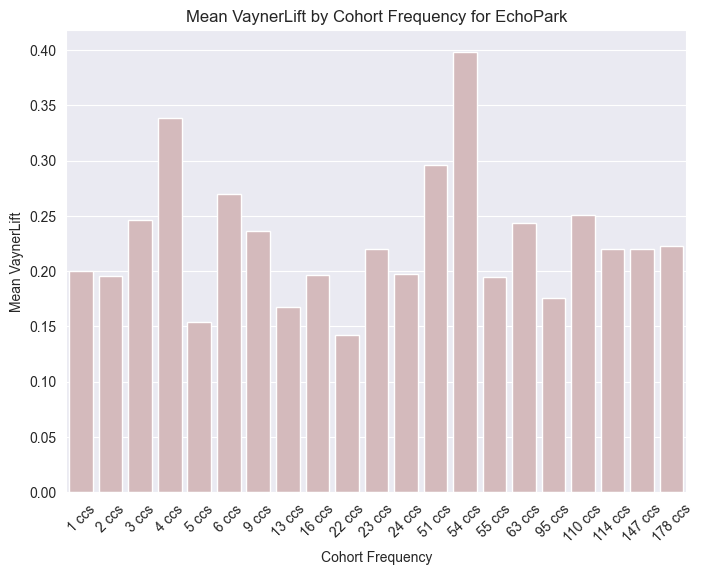

In [39]:
# 5. cohorts frequency and mean vayner lift
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Get the unique clients
unique_clients = cohort_df['Client'].unique()

# Print out the unique clients with their corresponding index
for i, client in enumerate(unique_clients):
    print(f"{i}: {client}")

# Ask for a numeric input
client_index = int(input("Enter the number corresponding to the client: "))

# Get the client corresponding to the input index
client = unique_clients[client_index]

# Subset the DataFrame to include only rows for this client
client_df = cohort_df[cohort_df['Client'] == client]

# Count the frequency of each cohort and create a new column 'Cohort Frequency'
client_df['Cohort Frequency'] = client_df.groupby('Cohort')['Cohort'].transform('count')

# Group by 'Cohort Frequency' and calculate the mean VaynerLift for each group
grouped_vaynerlift_means = client_df.groupby('Cohort Frequency')['VaynerLift'].mean()

# Create the bar plot
plt.figure(figsize=(8, 6))

# Create labels for x-axis
x_labels = [str(i) + ' ccs' for i in grouped_vaynerlift_means.index]

sns.barplot(x=x_labels, y=grouped_vaynerlift_means.values, color='#D8B6B9')

# Add labels and title
plt.xlabel('Cohort Frequency')
plt.ylabel('Mean VaynerLift')
plt.title(f'Mean VaynerLift by Cohort Frequency for {client}')

# Add data point labels
# for i, v in enumerate(grouped_vaynerlift_means.values):
#     plt.text(i, v + 0.01, str(round(v, 2)), color='black', ha='center')

plt.xticks(rotation=45)

# Show the plot
plt.show()


In [40]:
# Outlier with one data point and highest Vayner lift (not plotted on the graph)
cohorts_80 = client_df[client_df['Cohort Frequency'] >= 80]['Cohort'].unique()
print(cohorts_80)

['eCARnomists' 'Perpetual Browsers' 'New Car New Me'
 'Inexperienced Enthusiasts' 'The Introvert']


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/2909705276.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohorts_df['Cohort Frequency'] =  cohorts_df.groupby('Cohort')['Cohort'].transform('count')


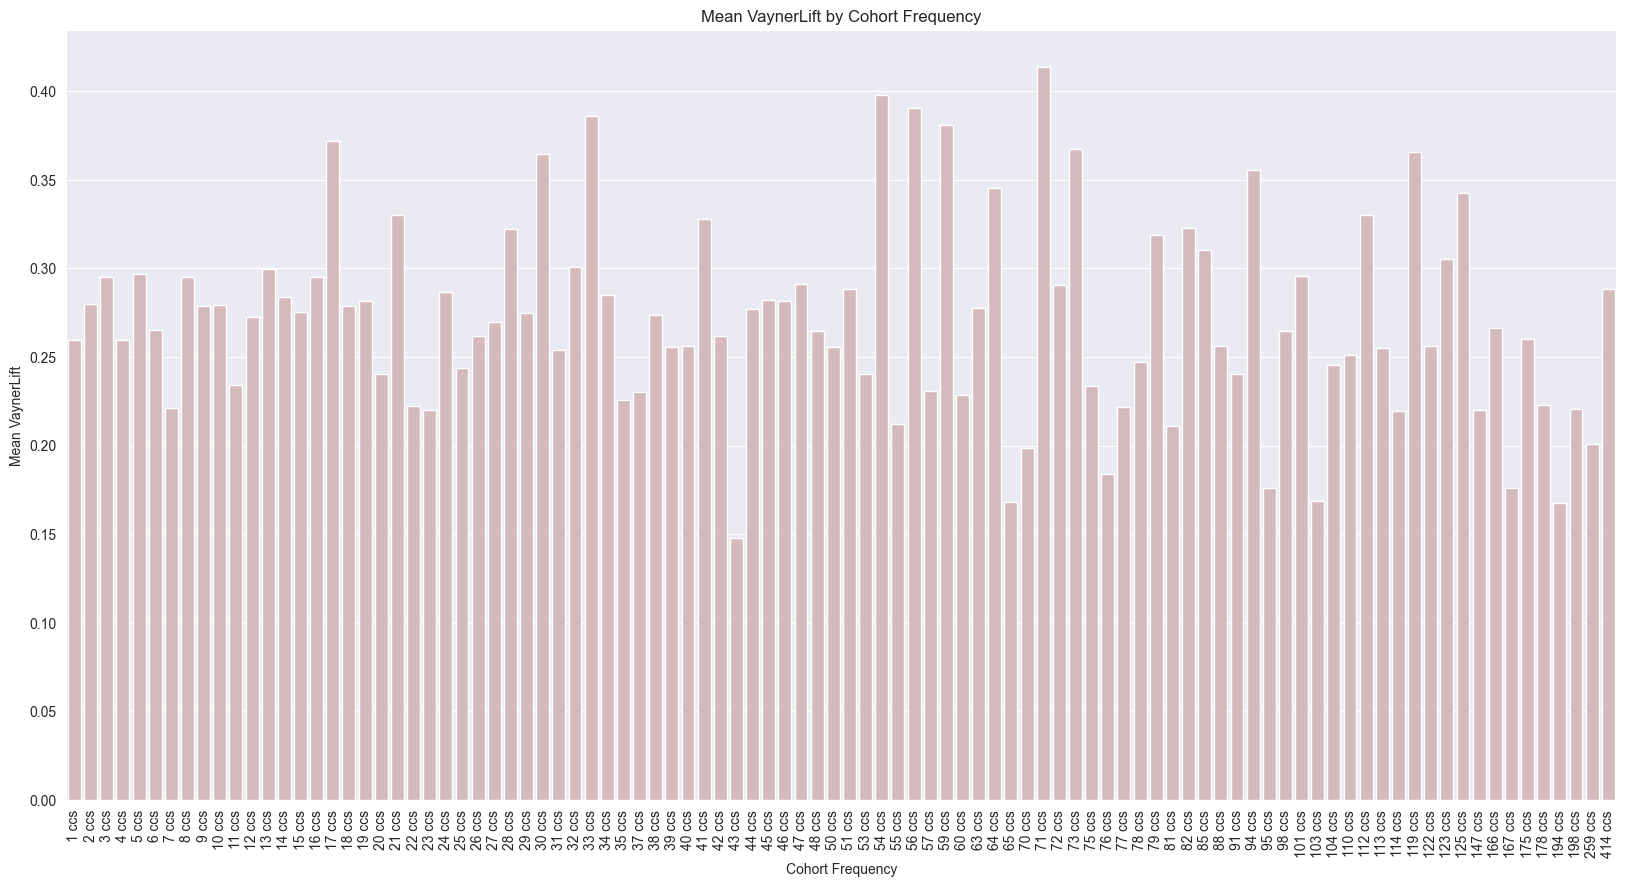

In [41]:
# Cohort frequency vs. VaynerLift for all clients

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

conditions = [
    df['CohortCat'] == 'Cohort',
]

combined_condition = np.logical_or.reduce(conditions)
cohorts_df = df[combined_condition]

# Count the frequency of each cohort and create a new column 'Cohort Frequency'
cohorts_df['Cohort Frequency'] =  cohorts_df.groupby('Cohort')['Cohort'].transform('count')

# Group by 'Cohort Frequency' and calculate the mean VaynerLift for each group
grouped_vaynerlift_means = cohorts_df.groupby('Cohort Frequency')['VaynerLift'].mean()

# Create the bar plot
plt.figure(figsize=(20, 10))

# Create labels for x-axis
x_labels = [str(i) + ' ccs' for i in grouped_vaynerlift_means.index]

sns.barplot(x=x_labels, y=grouped_vaynerlift_means.values, color='#D8B6B9')

# Add labels and title
plt.xlabel('Cohort Frequency')
plt.ylabel('Mean VaynerLift')
plt.title('Mean VaynerLift by Cohort Frequency')

# # Add data point labels
# for i, v in enumerate(grouped_vaynerlift_means.values):
#    plt.text(i, v + 0.01, str(round(v, 2)), color='black', ha='center')
plt.xticks(rotation=90)

# Show the plot
plt.show()


In [42]:
cohorts_df.shape

(13990, 26)

In [43]:
# Filter cohorts with frequency > 100
high_frequency_cohorts = cohorts_df[cohorts_df['Cohort Frequency'] > 150]

# Print unique cohorts from the filtered dataframe
print(high_frequency_cohorts['Cohort'].unique())


['Fleet Managers' 'Cocktail' 'Perpetual Browsers'
 'Streetwear Is All I Wear' 'Small Business Owners' 'Promo / Sale Content'
 'Next Level Sheep Counters' 'Sleepers Bridge']


In [44]:
cohorts_df = cohorts_df.rename(columns={'post_date': 'Post Date'})

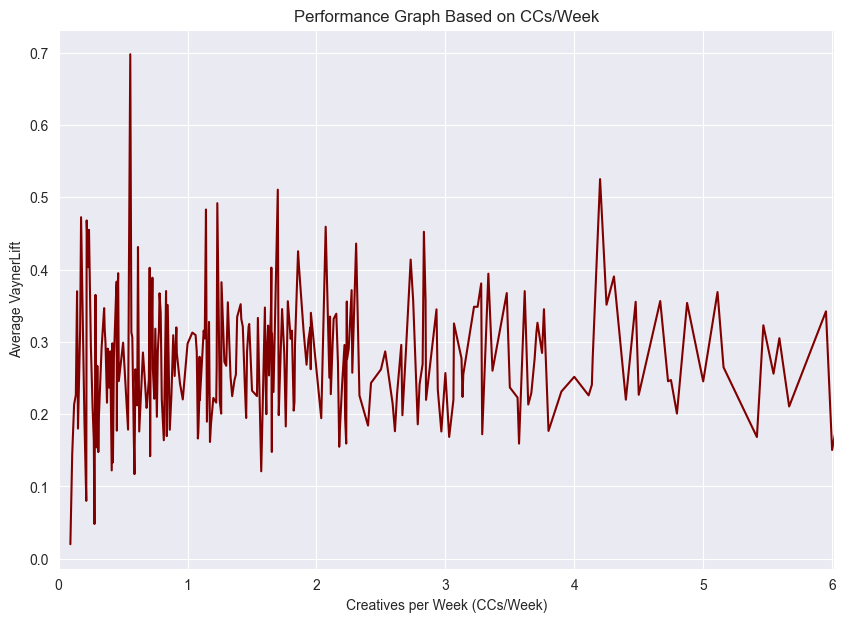

In [45]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming not_wildcard_df is already loaded
# Convert 'Post Date' column to datetime
cohorts_df['Post Date'] = pd.to_datetime(cohorts_df['Post Date'])
# Sort the DataFrame by 'Post Date'
cohorts_df = cohorts_df.sort_values(by='Post Date')

# Determine the start date for each cohort
start_dates = cohorts_df.groupby('Cohort')['Post Date'].min()

# Calculate the number of weeks since the first post for each cohort
weeks_since_start = ((cohorts_df['Post Date'] - cohorts_df['Cohort'].map(start_dates)) / timedelta(days=7))
weeks_since_start = weeks_since_start.fillna(0).replace([float('inf'), float('-inf')], 0).astype(int) + 1
cohorts_df['Weeks Since Start'] = weeks_since_start

# Calculate average creatives per week for each cohort
ccs_per_week = cohorts_df.groupby('Cohort').size() / cohorts_df.groupby('Cohort')['Weeks Since Start'].max()
cohorts_df['CCs/Week'] = cohorts_df['Cohort'].map(ccs_per_week)

# Calculate the mean VaynerLift for each 'CCs/Week' bin
grouped_vaynerlift_means = cohorts_df.groupby('CCs/Week')['VaynerLift'].mean()

# Create the performance graph
plt.figure(figsize=(10, 7))
plt.xlim(0, 6.012)
         
# Plot data
sns.lineplot(x=grouped_vaynerlift_means.index, y=grouped_vaynerlift_means.values, color='maroon')

# Add labels and title
plt.xlabel('Creatives per Week (CCs/Week)')
plt.ylabel('Average VaynerLift')
plt.title('Performance Graph Based on CCs/Week')

plt.show()


In [46]:
# Get the unique bin values (CCs/Week) 
unique_bins = cohorts_df['CCs/Week'].unique()
rounded_bins = [round(bin_value, 2) for bin_value in unique_bins]
rounded_bins_sorted = sorted(rounded_bins)
rounded_bins_sorted


[0.09,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.17,
 0.17,
 0.2,
 0.21,
 0.22,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.29,
 0.3,
 0.31,
 0.31,
 0.33,
 0.35,
 0.36,
 0.36,
 0.38,
 0.38,
 0.38,
 0.39,
 0.39,
 0.4,
 0.41,
 0.42,
 0.42,
 0.42,
 0.43,
 0.44,
 0.45,
 0.45,
 0.45,
 0.46,
 0.47,
 0.5,
 0.54,
 0.55,
 0.56,
 0.56,
 0.57,
 0.58,
 0.59,
 0.6,
 0.6,
 0.61,
 0.61,
 0.62,
 0.62,
 0.65,
 0.67,
 0.68,
 0.68,
 0.7,
 0.71,
 0.71,
 0.71,
 0.72,
 0.73,
 0.73,
 0.74,
 0.75,
 0.76,
 0.77,
 0.78,
 0.78,
 0.79,
 0.8,
 0.82,
 0.83,
 0.84,
 0.85,
 0.86,
 0.88,
 0.89,
 0.9,
 0.91,
 0.92,
 0.94,
 0.96,
 1.0,
 1.04,
 1.06,
 1.07,
 1.08,
 1.08,
 1.09,
 1.09,
 1.1,
 1.12,
 1.13,
 1.14,
 1.15,
 1.17,
 1.17,
 1.18,
 1.2,
 1.22,
 1.23,
 1.23,
 1.25,
 1.26,
 1.26,
 1.29,
 1.3,
 1.31,
 1.33,
 1.35,
 1.36,
 1.38,
 1.38,
 1.41,
 1.42,
 1.43,
 1.44,
 1.45,
 1.46,
 1.47,
 1.48,
 1.5,
 1.54,
 1.55,
 1.57,
 1.6,
 1.6,
 1.61,
 1.61,
 1.62,
 1.62,
 1.63,
 1.65,
 1.65,
 1.65,
 1.66,
 1.67,
 1.7,
 1

In [47]:
high_ccs_cohorts = cohorts_df[cohorts_df['CCs/Week'] > 6]

# Display these cohorts
print(high_ccs_cohorts[['Cohort', 'CCs/Week']].drop_duplicates())


                                                  Cohort   CCs/Week
17503                                    Sleepers Bridge   8.736842
16062       Couples (and family) Moving Up & In Together   6.583333
13976                                           Cocktail  12.545455
13703                                             Gamers   9.000000
12958                                  Ford Ride-Or-Dies   7.000000
12503                                Presidents Day Sale   7.333333
12463                                  Pace the Pace Car   7.714286
11630  Seasonal Wardrobe Refreshers Who Are Excited T...   6.230769
10753                           Streetwear Is All I Wear   8.818182
10622  NOSTALGIC MILLENIALS SPENDING DISPOSABLE INCOM...   8.000000
10628  NOSTALGIC MILLENNIALS SPENDING DISPOSABLE INCO...   9.375000
10541  TWITTER SCROLLING SPORTS FANS WATCHING LIVE TO...   6.222222
9505                                Promo / Sale Content  11.133333
8954   YOUNG KISS CAM HOPEFULS TAKING  MATCHES O

In [48]:
# Performance graph for a specific client for VL vs. CCs/week
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_graph_for_client(client_name, dataframe):
    
    # Filter the dataframe for the specified client
    client_df = dataframe[dataframe['Client'] == client_name]
    
    # Convert 'Post Date' column to datetime (if it's not already)
    if client_df['Post Date'].dtype != 'datetime64[ns]':
        client_df['Post Date'] = pd.to_datetime(client_df['Post Date'])
        
    # Sort the DataFrame by 'Post Date'
    client_df = client_df.sort_values(by='Post Date')

    # Remove rows where 'Cohort' is 'None'
    client_df = client_df.loc[client_df['CohortCat'] != 'no cohort']

    # Calculate the mean VaynerLift for each 'CCs/Week' bin
    grouped_vaynerlift_means = client_df.groupby('CCs/Week')['VaynerLift'].mean()

    # Create the performance graph
    plt.figure(figsize=(10, 7))
    #plt.xlim(0, 6.012)
             
    # Plot data
    sns.lineplot(x=grouped_vaynerlift_means.index, y=grouped_vaynerlift_means.values, color='maroon')

    # Add labels and title
    plt.xlabel('Creatives per Week (CCs/Week)')
    plt.ylabel('Average VaynerLift')
    plt.title(f'Performance Graph for {client_name} Based on CCs/Week')

    plt.show()

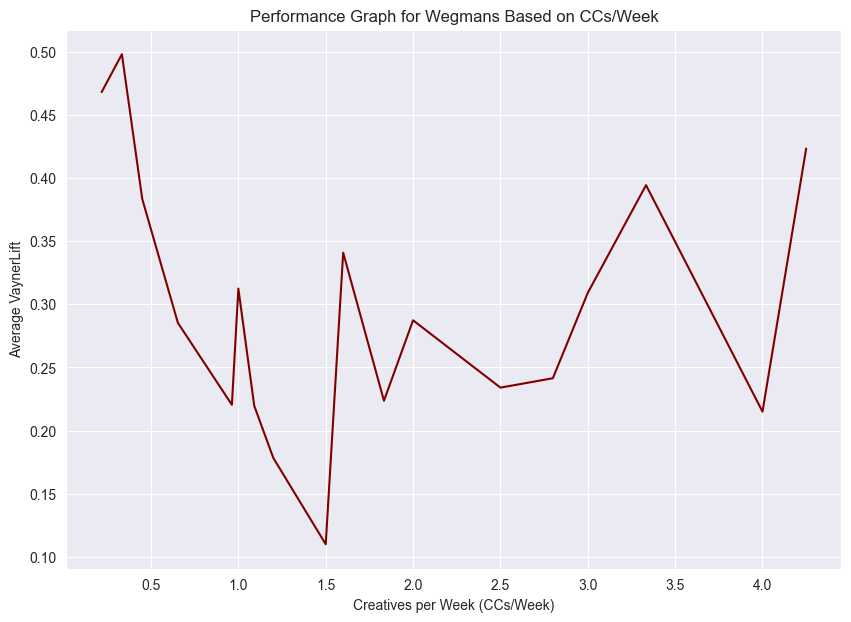

In [49]:
plot_graph_for_client("Wegmans", cohorts_df)

In [50]:
cohorts_df.to_csv("final_df.csv", index=False)


## Will's Analysis

In [83]:
cohorts_df.columns

Index(['Client', 'Post Date', 'days_on', 'platform', 'post_id', 'post_copy',
       'ad_name', 'link', 'CohortCat', 'Cohort', 'asset_type', 'qual_score',
       'followers', 'Impressions', 'comments', 'shares', 'reactions',
       'videoviews', 'saves', 'replies', 'retweets', 'engagements',
       'post_clicks', 'post_link_clicks', 'VaynerLift', 'Cohort Frequency',
       'Weeks Since Start', 'CCs/Week', 'Start Date'],
      dtype='object')

In [75]:
from datetime import datetime, timedelta
# Convert 'Post Date' column to datetime
cohorts_df['Post Date'] = pd.to_datetime(cohorts_df['Post Date'])
# Sort the DataFrame by 'Post Date'
cohorts_df = cohorts_df.sort_values(by='Post Date')

In [76]:
filtered_df = cohorts_df

# Determine the start date for each cohort
start_dates = filtered_df.groupby('Client')['Post Date'].min()


# Calculate the number of creatives made per week
filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)

In [100]:
def agg_cc_freq(x):
    d = {}
    x_sorted = x.sort_values(by='Weeks Since Start')
    weeks_between_posts = x_sorted['Weeks Since Start'].diff().dropna()

    d['num_cc'] = x.shape[0]
    d['num_weeks_ran'] = x['Weeks Since Start'].max()
    d['avg_weeks_since_first_cc'] = x['Weeks Since Start'].mean().round(0)
    d['median_weeks_since_first_cc'] = x['Weeks Since Start'].median()
    d['avg_weeks_btwn_posts'] = weeks_between_posts.mean().round(3)
    d['std_weeks_btwn_posts'] = weeks_between_posts.std()
    
    if d['num_weeks_ran'] > 0:
        d['relative_std_gap'] = round(weeks_between_posts.std() *100/ d['num_weeks_ran'],2)
        d['CCs/Week'] = (d['num_cc'] / d['num_weeks_ran']).round(2) # Calculating CCs/Week
    else:
        d['relative_std_gap'] = np.nan
        d['CCs/Week'] = 0  # Assuming 0 if 'num_weeks_ran' is 0 to avoid division by zero

    d['avg_vaynerlift'] = x['VaynerLift'].mean()
    d['median_vaynerlift'] = x['VaynerLift'].median()

    return pd.Series(d, list(d.keys()))

# Step 1: Redefine the modified agg_cc_freq function (as provided earlier)

# Step 2: Re-apply the function to filtered_df
grouped_vaynerlift_means = filtered_df.groupby('Client').apply(agg_cc_freq).reset_index()

# Step 3: Check the columns of the resulting dataframe
print(grouped_vaynerlift_means.columns)



Index(['Client', 'num_cc', 'num_weeks_ran', 'avg_weeks_since_first_cc',
       'median_weeks_since_first_cc', 'avg_weeks_btwn_posts',
       'std_weeks_btwn_posts', 'relative_std_gap', 'CCs/Week',
       'avg_vaynerlift', 'median_vaynerlift'],
      dtype='object')


In [101]:
grouped_vaynerlift_means.sort_values('median_vaynerlift', ascending=False).reset_index(drop=True)


,Client,num_cc,num_weeks_ran,avg_weeks_since_first_cc,median_weeks_since_first_cc,avg_weeks_btwn_posts,std_weeks_btwn_posts,relative_std_gap,CCs/Week,avg_vaynerlift,median_vaynerlift
0,Duolingo,32.0,13.0,5.0,4.5,0.387,0.615219,4.73,2.46,0.494062,0.505
1,Ticketmaster,6.0,5.0,3.0,2.0,0.800,1.095445,21.91,1.20,0.466667,0.470
2,Alton Towers,38.0,4.0,2.0,1.0,0.081,0.276725,6.92,9.50,0.361053,0.370
3,Flamin Hot,138.0,26.0,10.0,8.0,0.182,0.406183,1.56,5.31,0.356884,0.340
4,Thomas&Friends,51.0,8.0,3.0,3.0,0.140,0.350510,4.38,6.38,0.389412,0.310
5,Coach,279.0,24.0,10.0,10.0,0.083,0.275976,1.15,11.62,0.314624,0.270
6,Zoom,14.0,6.0,2.0,1.5,0.385,0.650444,10.84,2.33,0.287857,0.265
7,Wegmans,99.0,13.0,5.0,3.0,0.122,0.329489,2.53,7.62,0.308283,0.250
8,Kimberly Clark,765.0,29.0,9.0,7.0,0.037,0.188022,0.65,26.38,0.284771,0.220
9,NatWest,65.0,6.0,3.0,2.0,0.078,0.270490,4.51,10.83,0.307385,0.220


<Axes: xlabel='avg_weeks_btwn_posts', ylabel='avg_vaynerlift'>

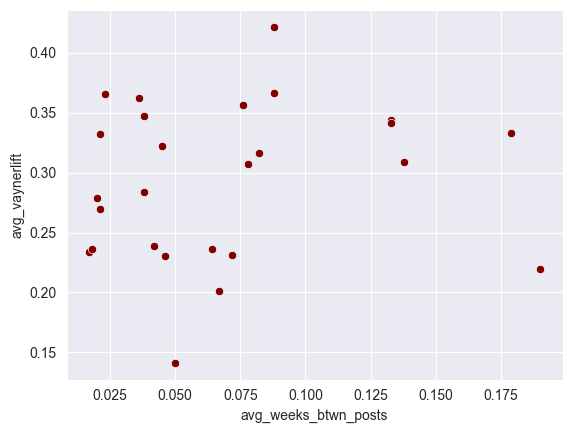

In [82]:
#Plot the average weeks between posts against the average vaynerlifts per post for each cohort
plt.figure
sns.scatterplot(x='avg_weeks_btwn_posts', y='avg_vaynerlift', data=grouped_vaynerlift_means, color = 'maroon')
#plt.xlim(0,1.5)

<Axes: xlabel='CCs/Week', ylabel='avg_vaynerlift'>

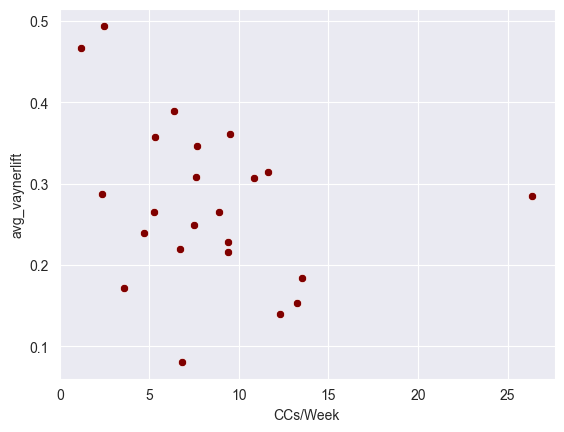

In [102]:
#Plot the average weeks between posts against the average vaynerlifts per post for each cohort
plt.figure
sns.scatterplot(x='CCs/Week', y='avg_vaynerlift', data=grouped_vaynerlift_means, color = 'maroon')
#plt.xlim(0,1.5)

In [94]:
grouped_vaynerlift_means.columns

Index(['Client', 'num_cc', 'num_weeks_ran', 'avg_weeks_since_first_cc',
       'median_weeks_since_first_cc', 'avg_weeks_btwn_posts',
       'std_weeks_btwn_posts', 'relative_std_gap', 'avg_vaynerlift',
       'median_vaynerlift'],
      dtype='object')

Data for Platform: TikTok


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17658,Casper,2022-05-31,7,TikTok,7104008233593130286,Red flag or dealbreaker?,What Time does the Flow Start,https://www.tiktok.com/@casper/video/710400823...,Cohort,Sleepless Spouses in Separate Rooms,...,0,0,25,0,0,0.25,47,1,1.093023,2022-05-31
17657,Casper,2022-05-31,7,TikTok,7103979919390264622,When he doesn't own a Casper 🚩🚩🚩🚩🚩🚩🚩🚩🚩,The Sweater,https://www.tiktok.com/@casper/video/710397991...,Cohort,Sleepless Spouses in Separate Rooms,...,0,0,16,0,0,0.06,47,1,1.093023,2022-05-31
17656,Casper,2022-05-31,7,TikTok,7103951438207847726,Just say no to bad sleep #Justsayno #sleeptok ...,This is you,https://www.tiktok.com/@casper/video/710395143...,Cohort,Next Level Sheep Counters,...,0,0,42,0,0,0.31,198,1,4.500000,2022-05-31
17655,Casper,2022-06-01,8,TikTok,7104364345705925934,"Handsome, well-rested, ready to tackle the day...",You With A Casper,https://www.tiktok.com/@casper/video/710436434...,Cohort,Next Level Sheep Counters,...,0,0,5,0,0,0.17,198,1,4.500000,2022-05-31
17654,Casper,2022-06-01,8,TikTok,7104300922867682602,It’s time to be a sleep girlie.,One Thing About Me,https://www.tiktok.com/@casper/video/710430092...,Cohort,"""Good Enough"" Non Consumers",...,0,0,13,0,0,0.32,6,1,3.000000,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1018280645.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


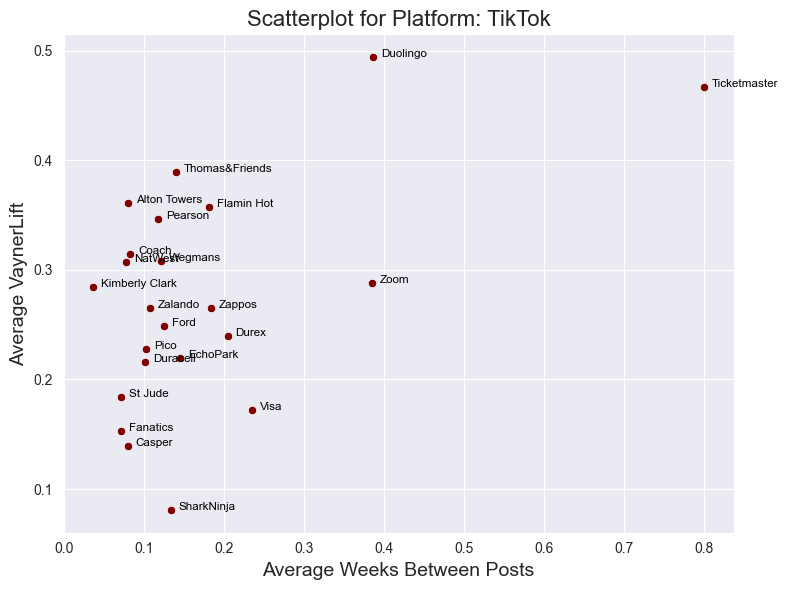

Data for Platform: Instagram


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17584,Casper,2022-06-30,15,Instagram,Cfbo3PFDGsi,Sleeping in my Casper is the only cure that wo...,Hangover Cure,https://www.instagram.com/reel/Cfbo3PFDGsi/,Cohort,"Work Hard, Play Hard, Sleep Harders",...,0,0,270,0,0,0.36,18,4,3.000000,2022-05-31
17585,Casper,2022-06-30,15,Instagram,CfboZWXDwAK,They’re gonna have to drag me out of here to g...,WFH Snooze,https://www.instagram.com/reel/CfboZWXDwAK/,Cohort,WFH to Stay In Bed Longer,...,0,0,1,0,0,0.00,75,2,1.829268,2022-05-31
17586,Casper,2022-06-30,15,Instagram,CfcEX2ZjPqv,Let’s see your cosiest blanket fort. #nostalgi...,No Fever,https://www.instagram.com/reel/CfcEX2ZjPqv/,Cohort,Extroverted About Being Introverts,...,0,0,239,0,0,0.33,70,4,1.707317,2022-05-31
17583,Casper,2022-07-01,17,Instagram,CfeWATTj80Y,Waiting for the next update 🍎 so I can get som...,Unsend,https://www.instagram.com/reel/CfeWATTj80Y/,Cohort,"Work Hard, Play Hard, Sleep Harders",...,0,0,0,0,0,0.00,18,4,3.000000,2022-05-31
17582,Casper,2022-07-01,13,Instagram,CfeIl9ljWxP,Good sleep can really bring you places #dream ...,Dream Land,https://www.instagram.com/reel/CfeIl9ljWxP/,Cohort,"Work Hard, Play Hard, Sleep Harders",...,0,0,2,0,0,0.00,18,4,3.000000,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1018280645.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


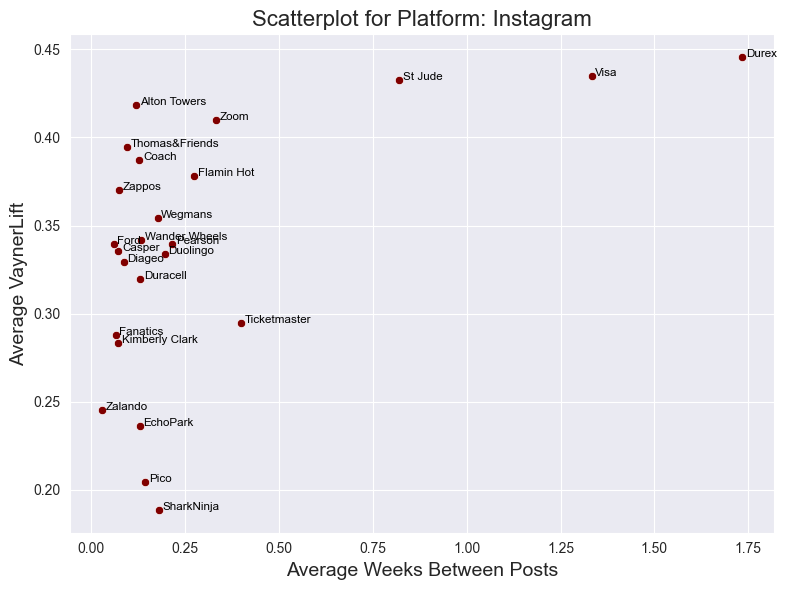

Data for Platform: Facebook


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17566,Casper,2022-07-11,14,Facebook,ehfOUjYkCk,Chill in the shade this season (with or withou...,Leafy Oasis,https://fb.watch/ehfOUjYkCk/,Cohort,Up at All Hours Vampire Workers,...,0,0,3,0,0,0.02,20,1,2.500000,2022-05-31
17561,Casper,2022-07-12,14,Facebook,2463184760524995,Drift into your summer of slumber with Casper.,Lazy River Oasis,https://www.facebook.com/Casper/photos/a.26261...,Cohort,InstaBragging Material Girls/Boys,...,0,0,2,0,0,0.07,85,1,2.236842,2022-05-31
17553,Casper,2022-07-13,14,Facebook,ehgPMD082G,Time to plug in and unplug,Charge,https://fb.watch/ehgPMD082G/,Cohort,Late Night Doom & Dopamine Scrollers,...,0,0,9,0,0,0.04,101,1,2.657895,2022-05-31
17552,Casper,2022-07-13,14,Facebook,ehgOEx2xn4,Find your away-from-the-crowd oasis this summe...,Desert Oasis,https://fb.watch/ehgOEx2xn4/,Cohort,Frequent Jet Setters Who Miss Their Bed,...,0,0,8,0,0,0.03,27,1,1.800000,2022-05-31
17551,Casper,2022-07-13,14,Facebook,2464104053766399,Sleep on it.,Vaca or Nap?,https://www.facebook.com/Casper/photos/a.26261...,Cohort,Frequent Jet Setters Who Miss Their Bed,...,0,0,8,0,0,0.66,27,1,1.800000,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1018280645.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


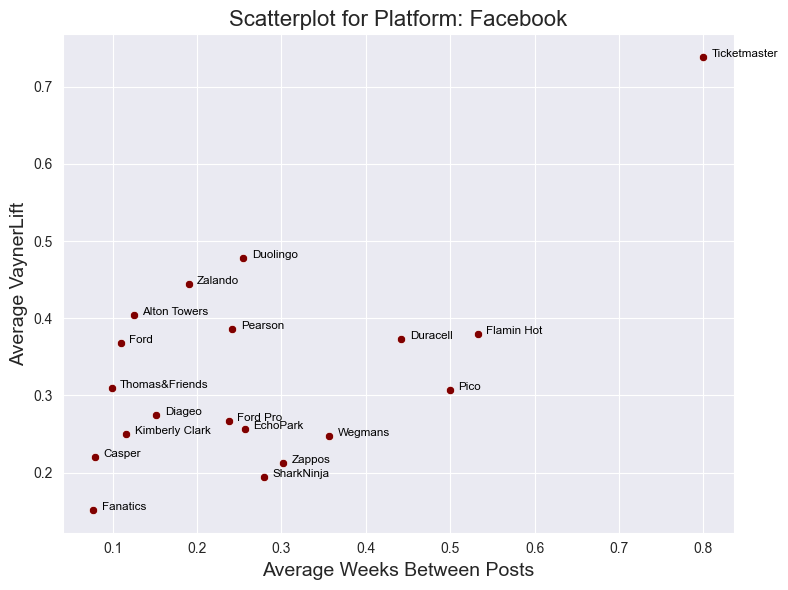

Data for Platform: YouTube


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17560,Casper,2022-07-13,14,YouTube,WMtY-0DgK-8,It’s really that simple.,New Hack,https://youtube.com/shorts/WMtY-0DgK-8?feature...,Cohort,There’s an App for That Modern Health Hackers,...,0,0,83,0,0,0.40,4,1,0.444444,2022-05-31
17558,Casper,2022-07-13,14,YouTube,Kb6jId5ghzc,Casper IS the moment #vibes,Comments in Auto Tune,https://youtube.com/shorts/Kb6jId5ghzc?feature...,Cohort,Late Night Doom & Dopamine Scrollers,...,0,0,15,0,0,0.26,101,1,2.657895,2022-05-31
17559,Casper,2022-07-13,14,YouTube,VvoSx4dofoA,We'll be here when you get back. #nosleep #tra...,Vaycay Sleep,https://youtube.com/shorts/VvoSx4dofoA?feature...,Cohort,Frequent Jet Setters Who Miss Their Bed,...,0,0,55,0,0,0.36,27,1,1.800000,2022-05-31
17532,Casper,2022-07-19,14,YouTube,8mBThsvBOzE,"Don't rely on a quick fix for a good sleep, ju...",Nightcap,https://youtube.com/shorts/8mBThsvBOzE?feature...,Cohort,Work Hard Play Hard Sleep Harders,...,0,0,44,0,0,0.18,35,1,2.692308,2022-05-31
17486,Casper,2022-07-28,14,YouTube,f9cGPFY_W2o,TT & Reels: Sound like a dream job come true? ...,Sleepers_TT_Announcement1,https://www.youtube.com/shorts/f9cGPFY_W2o,Cohort,Sleepers Bridge,...,0,0,19,0,0,0.29,166,1,8.736842,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1018280645.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


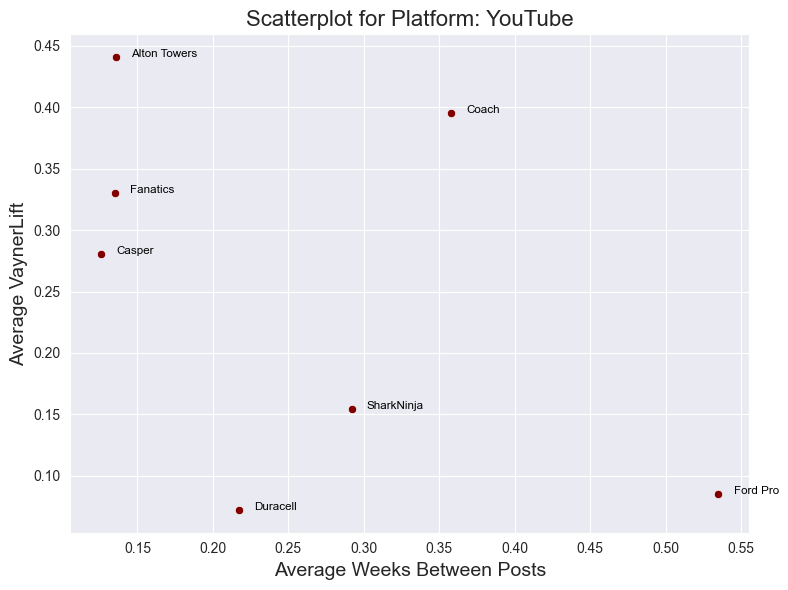

Data for Platform: Twitter


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17522,Casper,2022-07-22,14,Twitter,1550557083078213634,when the drink starts tasting like “pizza in b...,My drink starts tasting like,https://twitter.com/Casper/status/155055708307...,Cohort,Work Hard Play Hard Sleep Harders,...,0,0,1,0,0,0.05,35,1,2.692308,2022-05-31
17521,Casper,2022-07-23,13,Twitter,1550934592462340096,why is sleep the only skill where people say i...,Lazy Skill\n,https://twitter.com/Casper/status/155093459246...,Cohort,Work Hard Play Hard Sleep Harders,...,0,1,1,0,0,0.58,35,1,2.692308,2022-05-31
17519,Casper,2022-07-24,12,Twitter,1551373538606534656,whoever said “sleep was for the weak” was seri...,Sleep is NOT for the weak,https://twitter.com/Casper/status/155137353860...,Cohort,Work Hard Play Hard Sleep Harders,...,0,4,7,0,0,0.75,35,1,2.692308,2022-05-31
17514,Casper,2022-07-25,14,Twitter,1551568446839590913,make your bed every morning to distract from t...,"Bed Made, Life Messy",https://twitter.com/Casper/status/155156844683...,Cohort,Messy Hot Aunts Who Likes Their Bed Neat,...,0,0,4,0,0,0.05,15,1,1.250000,2022-05-31
17516,Casper,2022-07-25,14,Twitter,1551659113154691072,if you’ve ever looked at work and said “looks ...,All-Dayer\n,https://twitter.com/Casper/status/155165911315...,Cohort,Work Hard Play Hard Sleep Harders,...,0,0,2,0,0,0.05,35,1,2.692308,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1018280645.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


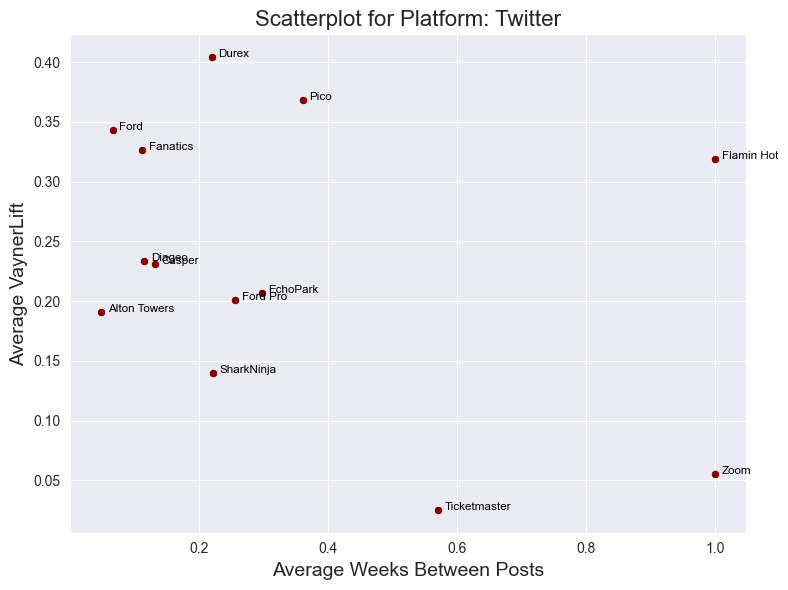

Data for Platform: Pinterest


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17492,Casper,2022-07-27,14,Pinterest,https://www.pinterest.com/pin/301600506306708424/,"Whether you make it first think or not at all,...",Bed making,https://www.pinterest.com/pin/301600506306708424/,Cohort,Messy Hot Aunts Who Likes Their Bed Neat,...,0,0,0,0,0,0.05,15,1,1.250000,2022-05-31
17488,Casper,2022-07-27,14,Pinterest,https://www.pinterest.com/pin/301600506306708223/,Headline: A mattress for new beginnings\nPost ...,"Updated, upgraded",https://www.pinterest.com/pin/301600506306708223/,Cohort,Couples and family Moving Up & In Together,...,0,0,0,0,0,0.05,51,1,4.250000,2022-05-31
17489,Casper,2022-07-27,14,Pinterest,https://www.pinterest.com/pin/301600506306708224/,The robes are good for pretty much everything ...,Casper Gear,https://www.pinterest.com/pin/301600506306708224/,Cohort,InstaBragging Material Girls/Boys,...,0,0,0,0,0,0.05,85,3,2.236842,2022-05-31
17490,Casper,2022-07-27,14,Pinterest,https://www.pinterest.com/pin/301600506306708421/,Headline: A bed you’ll never want to leave\nPo...,Night in is the new night out,https://www.pinterest.com/pin/301600506306708421/,Cohort,Couples and family Moving Up & In Together,...,0,0,0,0,0,0.03,51,1,4.250000,2022-05-31
17491,Casper,2022-07-27,14,Pinterest,https://www.pinterest.com/pin/301600506306708422/,Headline: Pillows for all your bedroom activit...,Up your pillow talk,https://www.pinterest.com/pin/301600506306708422/,Cohort,Couples and family Moving Up & In Together,...,0,0,0,0,0,0.05,51,1,4.250000,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1018280645.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


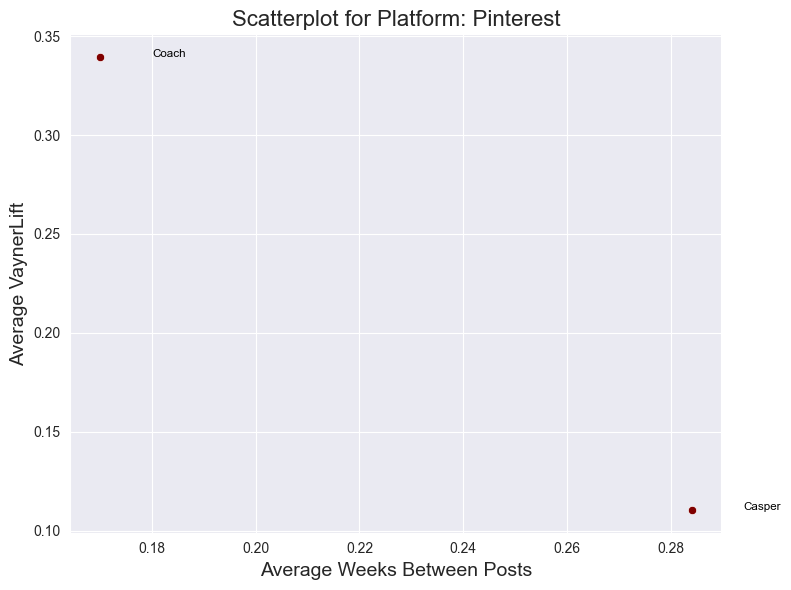

Data for Platform: LinkedIn


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17342,Ford Pro,2022-08-09,3,LinkedIn,https://www.linkedin.com/feed/update/urn:li:ac...,#FordPro is driving businesses forward with te...,Telematics Subcriptions,https://www.linkedin.com/feed/update/urn:li:ac...,Cohort,Investors,...,0,0,410,0,0,0.77,88,1,1.955556,2022-08-09
17056,Ford Pro,2022-08-30,1,LinkedIn,https://www.linkedin.com/feed/update/urn:li:ac...,"We’re moving beyond just trucks and vans, with...",Ted Quote,https://www.linkedin.com/feed/update/urn:li:ac...,Cohort,Investors,...,0,0,127,0,0,0.57,88,4,1.955556,2022-08-09
17035,Ford Pro,2022-08-31,10,LinkedIn,https://www.linkedin.com/feed/update/urn:li:ac...,#FordPro can help make your business more prod...,Wanda Quote,https://www.linkedin.com/feed/update/urn:li:ac...,Cohort,Investors,...,0,0,115,0,0,0.57,88,4,1.955556,2022-08-09
16898,Ford Pro,2022-09-08,12,LinkedIn,https://www.linkedin.com/feed/update/urn:li:ac...,This is Ford Pro™: leading execs,One-stop Video Series,https://www.linkedin.com/feed/update/urn:li:ac...,Cohort,Investors,...,0,0,99,0,0,0.43,88,5,1.955556,2022-08-09
16809,Ford Pro,2022-09-13,8,LinkedIn,https://www.linkedin.com/feed/update/urn:li:ac...,"Today, we're launching the Ford Pro™ Fleet Man...",Ford Pro™ Fleet Management solution launch,https://www.linkedin.com/feed/update/urn:li:ac...,Cohort,Fleet Managers,...,0,0,334,0,0,0.79,259,5,4.796296,2022-08-09


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1018280645.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


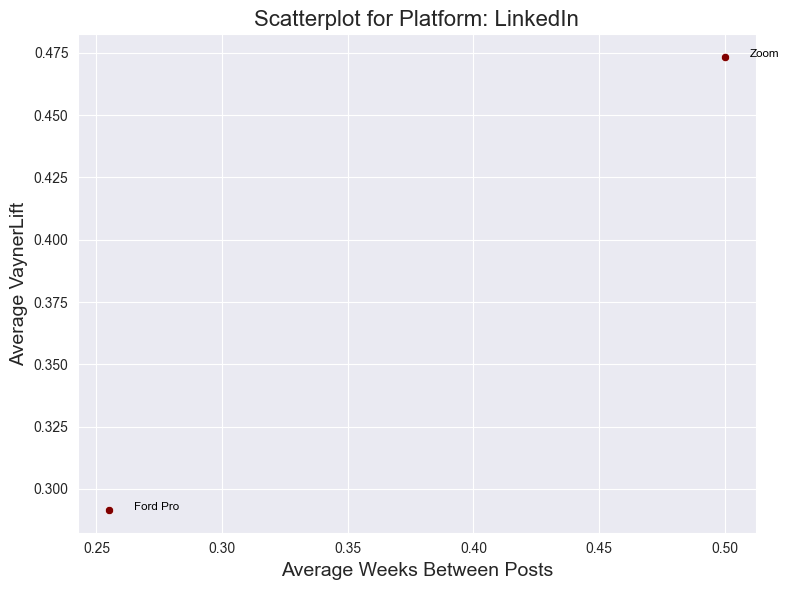

In [92]:
from IPython.display import display

# Loop through each unique platform
for platform in cohorts_df['platform'].unique():
    
    # Filter the dataframe by the current platform
    platform_df = cohorts_df[cohorts_df['platform'] == platform]
    
    # Display the filtered dataframe for the platform
    print(f"Data for Platform: {platform}")
    display(platform_df.head())  # Displays the top rows of the filtered dataframe; adjust to show more/less as needed
    
    # Follow the same analysis as before on the filtered data
    filtered_df = platform_df
    start_dates = filtered_df.groupby('Client')['Post Date'].min()
    filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)
    grouped_vaynerlift_means = filtered_df.groupby('Client').apply(agg_cc_freq).reset_index()
    grouped_vaynerlift_means.sort_values('median_vaynerlift', ascending=False).reset_index(drop=True)
    
    # Plot the scatterplot for the current platform
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='avg_weeks_btwn_posts', y='avg_vaynerlift', data=grouped_vaynerlift_means, color='maroon')
    
    # Label each point with its client name
    for line in range(0,grouped_vaynerlift_means.shape[0]):
         plt.text(grouped_vaynerlift_means.avg_weeks_btwn_posts[line]+0.01, 
                  grouped_vaynerlift_means.avg_vaynerlift[line], 
                  grouped_vaynerlift_means.Client[line], 
                  horizontalalignment='left', 
                  size='small', 
                  color='black')
    
    # Provide title and labels for clarity
    plt.title(f"Scatterplot for Platform: {platform}", fontsize=16)
    plt.xlabel('Average Weeks Between Posts', fontsize=14)
    plt.ylabel('Average VaynerLift', fontsize=14)
    
    # Display the scatterplot
    plt.tight_layout()
    plt.show()


Data for Platform: TikTok


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17658,Casper,2022-05-31,7,TikTok,7104008233593130286,Red flag or dealbreaker?,What Time does the Flow Start,https://www.tiktok.com/@casper/video/710400823...,Cohort,Sleepless Spouses in Separate Rooms,...,0,0,25,0,0,0.25,47,1,1.093023,2022-05-31
17657,Casper,2022-05-31,7,TikTok,7103979919390264622,When he doesn't own a Casper 🚩🚩🚩🚩🚩🚩🚩🚩🚩,The Sweater,https://www.tiktok.com/@casper/video/710397991...,Cohort,Sleepless Spouses in Separate Rooms,...,0,0,16,0,0,0.06,47,1,1.093023,2022-05-31
17656,Casper,2022-05-31,7,TikTok,7103951438207847726,Just say no to bad sleep #Justsayno #sleeptok ...,This is you,https://www.tiktok.com/@casper/video/710395143...,Cohort,Next Level Sheep Counters,...,0,0,42,0,0,0.31,198,1,4.500000,2022-05-31
17655,Casper,2022-06-01,8,TikTok,7104364345705925934,"Handsome, well-rested, ready to tackle the day...",You With A Casper,https://www.tiktok.com/@casper/video/710436434...,Cohort,Next Level Sheep Counters,...,0,0,5,0,0,0.17,198,1,4.500000,2022-05-31
17654,Casper,2022-06-01,8,TikTok,7104300922867682602,It’s time to be a sleep girlie.,One Thing About Me,https://www.tiktok.com/@casper/video/710430092...,Cohort,"""Good Enough"" Non Consumers",...,0,0,13,0,0,0.32,6,1,3.000000,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3692255972.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


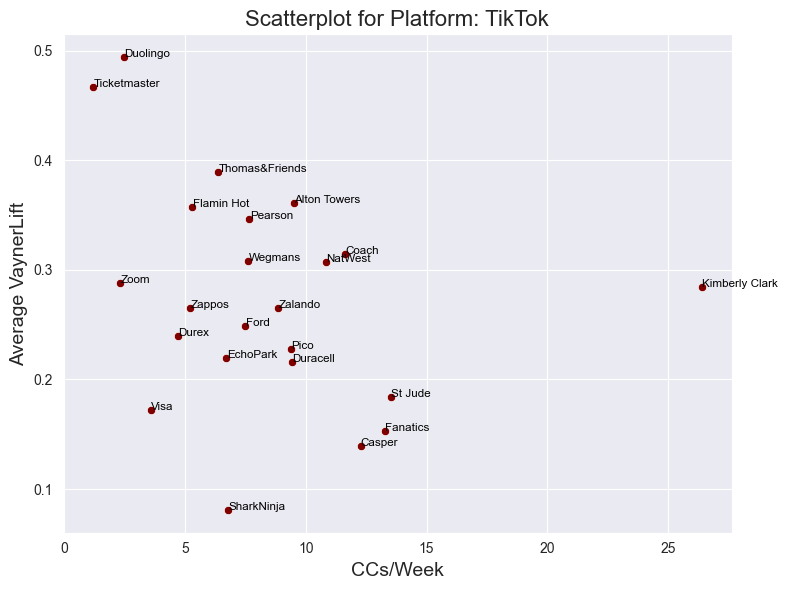

Data for Platform: Instagram


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17584,Casper,2022-06-30,15,Instagram,Cfbo3PFDGsi,Sleeping in my Casper is the only cure that wo...,Hangover Cure,https://www.instagram.com/reel/Cfbo3PFDGsi/,Cohort,"Work Hard, Play Hard, Sleep Harders",...,0,0,270,0,0,0.36,18,4,3.000000,2022-05-31
17585,Casper,2022-06-30,15,Instagram,CfboZWXDwAK,They’re gonna have to drag me out of here to g...,WFH Snooze,https://www.instagram.com/reel/CfboZWXDwAK/,Cohort,WFH to Stay In Bed Longer,...,0,0,1,0,0,0.00,75,2,1.829268,2022-05-31
17586,Casper,2022-06-30,15,Instagram,CfcEX2ZjPqv,Let’s see your cosiest blanket fort. #nostalgi...,No Fever,https://www.instagram.com/reel/CfcEX2ZjPqv/,Cohort,Extroverted About Being Introverts,...,0,0,239,0,0,0.33,70,4,1.707317,2022-05-31
17583,Casper,2022-07-01,17,Instagram,CfeWATTj80Y,Waiting for the next update 🍎 so I can get som...,Unsend,https://www.instagram.com/reel/CfeWATTj80Y/,Cohort,"Work Hard, Play Hard, Sleep Harders",...,0,0,0,0,0,0.00,18,4,3.000000,2022-05-31
17582,Casper,2022-07-01,13,Instagram,CfeIl9ljWxP,Good sleep can really bring you places #dream ...,Dream Land,https://www.instagram.com/reel/CfeIl9ljWxP/,Cohort,"Work Hard, Play Hard, Sleep Harders",...,0,0,2,0,0,0.00,18,4,3.000000,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3692255972.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


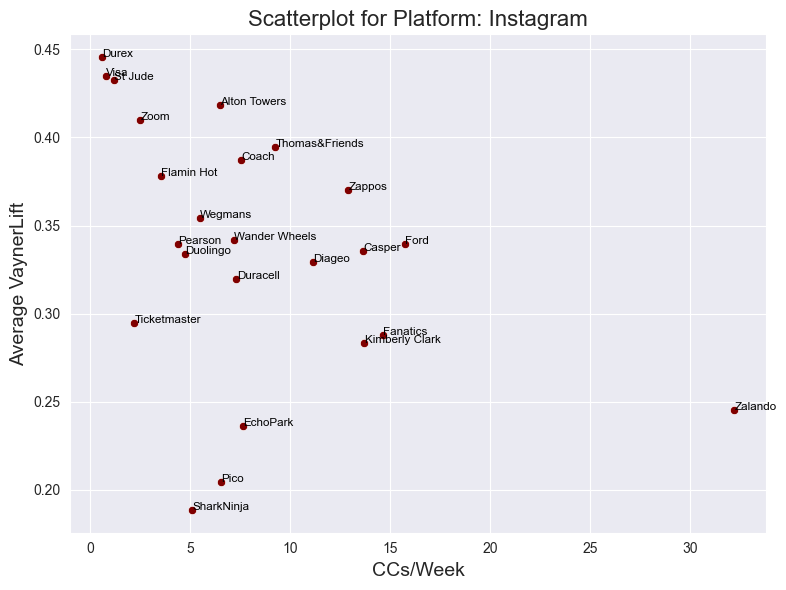

Data for Platform: Facebook


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17566,Casper,2022-07-11,14,Facebook,ehfOUjYkCk,Chill in the shade this season (with or withou...,Leafy Oasis,https://fb.watch/ehfOUjYkCk/,Cohort,Up at All Hours Vampire Workers,...,0,0,3,0,0,0.02,20,1,2.500000,2022-05-31
17561,Casper,2022-07-12,14,Facebook,2463184760524995,Drift into your summer of slumber with Casper.,Lazy River Oasis,https://www.facebook.com/Casper/photos/a.26261...,Cohort,InstaBragging Material Girls/Boys,...,0,0,2,0,0,0.07,85,1,2.236842,2022-05-31
17553,Casper,2022-07-13,14,Facebook,ehgPMD082G,Time to plug in and unplug,Charge,https://fb.watch/ehgPMD082G/,Cohort,Late Night Doom & Dopamine Scrollers,...,0,0,9,0,0,0.04,101,1,2.657895,2022-05-31
17552,Casper,2022-07-13,14,Facebook,ehgOEx2xn4,Find your away-from-the-crowd oasis this summe...,Desert Oasis,https://fb.watch/ehgOEx2xn4/,Cohort,Frequent Jet Setters Who Miss Their Bed,...,0,0,8,0,0,0.03,27,1,1.800000,2022-05-31
17551,Casper,2022-07-13,14,Facebook,2464104053766399,Sleep on it.,Vaca or Nap?,https://www.facebook.com/Casper/photos/a.26261...,Cohort,Frequent Jet Setters Who Miss Their Bed,...,0,0,8,0,0,0.66,27,1,1.800000,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3692255972.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


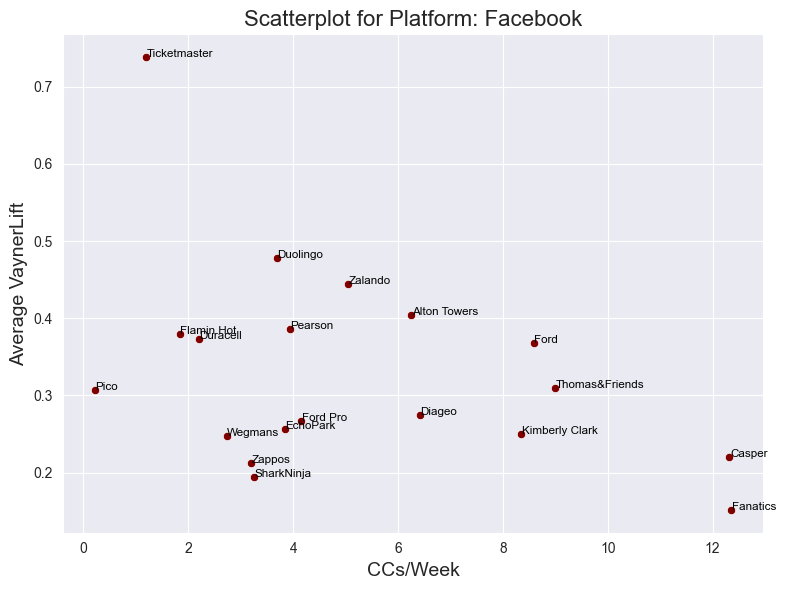

Data for Platform: YouTube


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17560,Casper,2022-07-13,14,YouTube,WMtY-0DgK-8,It’s really that simple.,New Hack,https://youtube.com/shorts/WMtY-0DgK-8?feature...,Cohort,There’s an App for That Modern Health Hackers,...,0,0,83,0,0,0.40,4,1,0.444444,2022-05-31
17558,Casper,2022-07-13,14,YouTube,Kb6jId5ghzc,Casper IS the moment #vibes,Comments in Auto Tune,https://youtube.com/shorts/Kb6jId5ghzc?feature...,Cohort,Late Night Doom & Dopamine Scrollers,...,0,0,15,0,0,0.26,101,1,2.657895,2022-05-31
17559,Casper,2022-07-13,14,YouTube,VvoSx4dofoA,We'll be here when you get back. #nosleep #tra...,Vaycay Sleep,https://youtube.com/shorts/VvoSx4dofoA?feature...,Cohort,Frequent Jet Setters Who Miss Their Bed,...,0,0,55,0,0,0.36,27,1,1.800000,2022-05-31
17532,Casper,2022-07-19,14,YouTube,8mBThsvBOzE,"Don't rely on a quick fix for a good sleep, ju...",Nightcap,https://youtube.com/shorts/8mBThsvBOzE?feature...,Cohort,Work Hard Play Hard Sleep Harders,...,0,0,44,0,0,0.18,35,1,2.692308,2022-05-31
17486,Casper,2022-07-28,14,YouTube,f9cGPFY_W2o,TT & Reels: Sound like a dream job come true? ...,Sleepers_TT_Announcement1,https://www.youtube.com/shorts/f9cGPFY_W2o,Cohort,Sleepers Bridge,...,0,0,19,0,0,0.29,166,1,8.736842,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3692255972.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


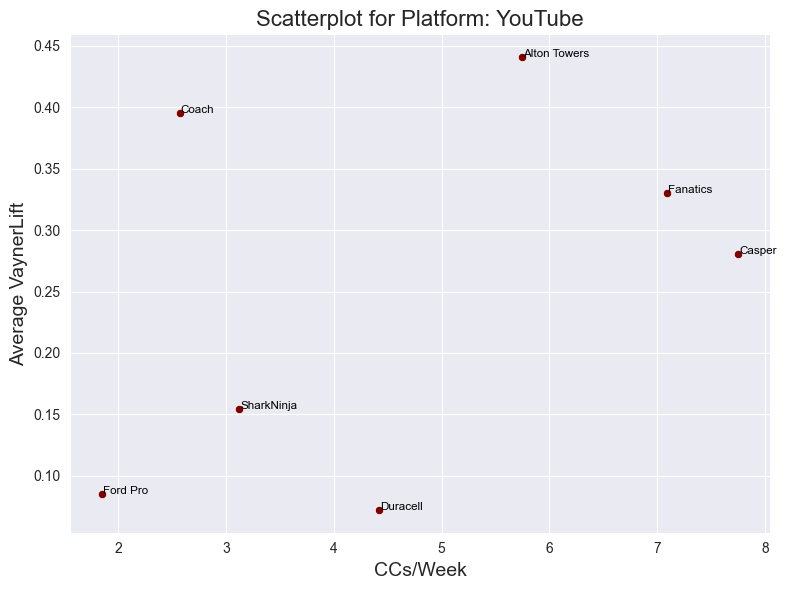

Data for Platform: Twitter


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17522,Casper,2022-07-22,14,Twitter,1550557083078213634,when the drink starts tasting like “pizza in b...,My drink starts tasting like,https://twitter.com/Casper/status/155055708307...,Cohort,Work Hard Play Hard Sleep Harders,...,0,0,1,0,0,0.05,35,1,2.692308,2022-05-31
17521,Casper,2022-07-23,13,Twitter,1550934592462340096,why is sleep the only skill where people say i...,Lazy Skill\n,https://twitter.com/Casper/status/155093459246...,Cohort,Work Hard Play Hard Sleep Harders,...,0,1,1,0,0,0.58,35,1,2.692308,2022-05-31
17519,Casper,2022-07-24,12,Twitter,1551373538606534656,whoever said “sleep was for the weak” was seri...,Sleep is NOT for the weak,https://twitter.com/Casper/status/155137353860...,Cohort,Work Hard Play Hard Sleep Harders,...,0,4,7,0,0,0.75,35,1,2.692308,2022-05-31
17514,Casper,2022-07-25,14,Twitter,1551568446839590913,make your bed every morning to distract from t...,"Bed Made, Life Messy",https://twitter.com/Casper/status/155156844683...,Cohort,Messy Hot Aunts Who Likes Their Bed Neat,...,0,0,4,0,0,0.05,15,1,1.250000,2022-05-31
17516,Casper,2022-07-25,14,Twitter,1551659113154691072,if you’ve ever looked at work and said “looks ...,All-Dayer\n,https://twitter.com/Casper/status/155165911315...,Cohort,Work Hard Play Hard Sleep Harders,...,0,0,2,0,0,0.05,35,1,2.692308,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3692255972.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


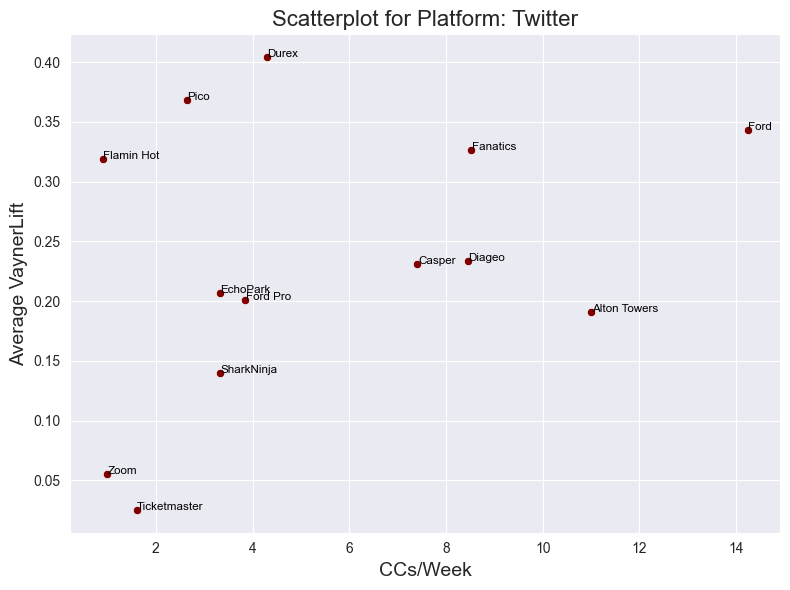

Data for Platform: Pinterest


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17492,Casper,2022-07-27,14,Pinterest,https://www.pinterest.com/pin/301600506306708424/,"Whether you make it first think or not at all,...",Bed making,https://www.pinterest.com/pin/301600506306708424/,Cohort,Messy Hot Aunts Who Likes Their Bed Neat,...,0,0,0,0,0,0.05,15,1,1.250000,2022-05-31
17488,Casper,2022-07-27,14,Pinterest,https://www.pinterest.com/pin/301600506306708223/,Headline: A mattress for new beginnings\nPost ...,"Updated, upgraded",https://www.pinterest.com/pin/301600506306708223/,Cohort,Couples and family Moving Up & In Together,...,0,0,0,0,0,0.05,51,1,4.250000,2022-05-31
17489,Casper,2022-07-27,14,Pinterest,https://www.pinterest.com/pin/301600506306708224/,The robes are good for pretty much everything ...,Casper Gear,https://www.pinterest.com/pin/301600506306708224/,Cohort,InstaBragging Material Girls/Boys,...,0,0,0,0,0,0.05,85,3,2.236842,2022-05-31
17490,Casper,2022-07-27,14,Pinterest,https://www.pinterest.com/pin/301600506306708421/,Headline: A bed you’ll never want to leave\nPo...,Night in is the new night out,https://www.pinterest.com/pin/301600506306708421/,Cohort,Couples and family Moving Up & In Together,...,0,0,0,0,0,0.03,51,1,4.250000,2022-05-31
17491,Casper,2022-07-27,14,Pinterest,https://www.pinterest.com/pin/301600506306708422/,Headline: Pillows for all your bedroom activit...,Up your pillow talk,https://www.pinterest.com/pin/301600506306708422/,Cohort,Couples and family Moving Up & In Together,...,0,0,0,0,0,0.05,51,1,4.250000,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3692255972.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


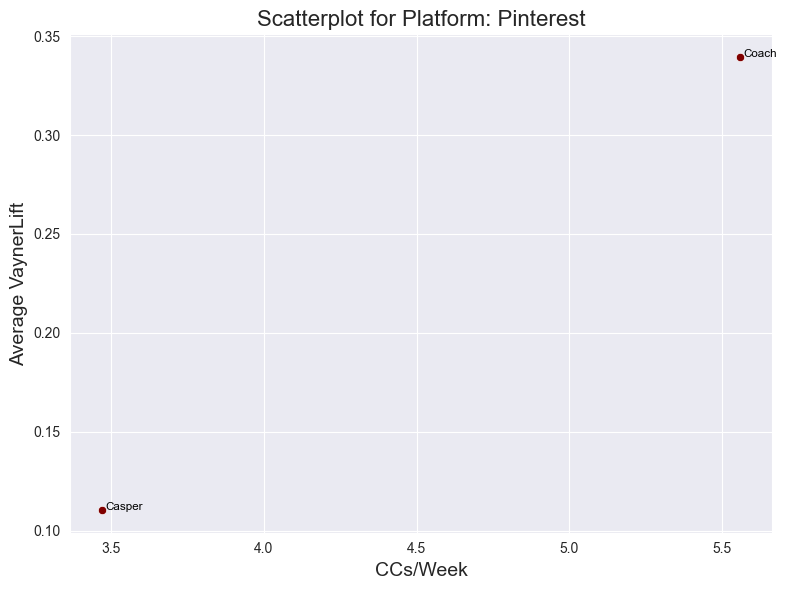

Data for Platform: LinkedIn


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17342,Ford Pro,2022-08-09,3,LinkedIn,https://www.linkedin.com/feed/update/urn:li:ac...,#FordPro is driving businesses forward with te...,Telematics Subcriptions,https://www.linkedin.com/feed/update/urn:li:ac...,Cohort,Investors,...,0,0,410,0,0,0.77,88,1,1.955556,2022-08-09
17056,Ford Pro,2022-08-30,1,LinkedIn,https://www.linkedin.com/feed/update/urn:li:ac...,"We’re moving beyond just trucks and vans, with...",Ted Quote,https://www.linkedin.com/feed/update/urn:li:ac...,Cohort,Investors,...,0,0,127,0,0,0.57,88,4,1.955556,2022-08-09
17035,Ford Pro,2022-08-31,10,LinkedIn,https://www.linkedin.com/feed/update/urn:li:ac...,#FordPro can help make your business more prod...,Wanda Quote,https://www.linkedin.com/feed/update/urn:li:ac...,Cohort,Investors,...,0,0,115,0,0,0.57,88,4,1.955556,2022-08-09
16898,Ford Pro,2022-09-08,12,LinkedIn,https://www.linkedin.com/feed/update/urn:li:ac...,This is Ford Pro™: leading execs,One-stop Video Series,https://www.linkedin.com/feed/update/urn:li:ac...,Cohort,Investors,...,0,0,99,0,0,0.43,88,5,1.955556,2022-08-09
16809,Ford Pro,2022-09-13,8,LinkedIn,https://www.linkedin.com/feed/update/urn:li:ac...,"Today, we're launching the Ford Pro™ Fleet Man...",Ford Pro™ Fleet Management solution launch,https://www.linkedin.com/feed/update/urn:li:ac...,Cohort,Fleet Managers,...,0,0,334,0,0,0.79,259,5,4.796296,2022-08-09


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3692255972.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


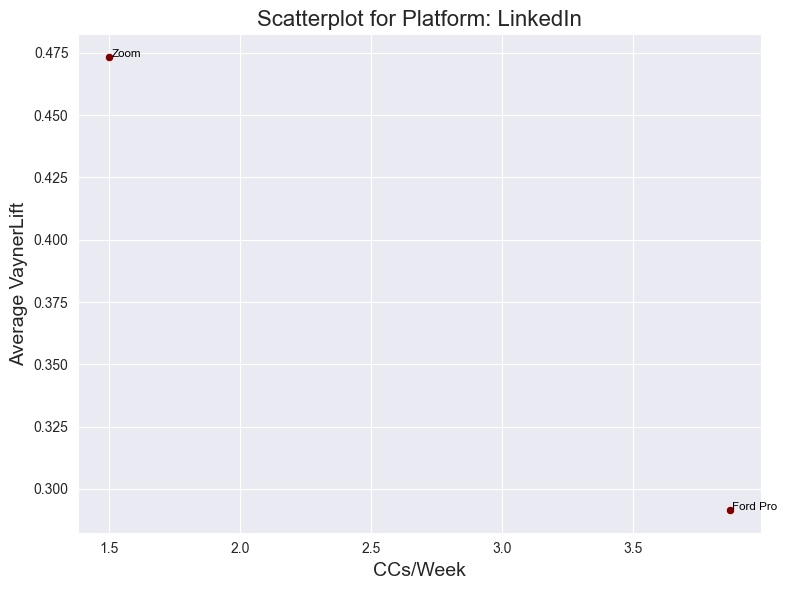

Data for Platform: TikTok


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17658,Casper,2022-05-31,7,TikTok,7104008233593130286,Red flag or dealbreaker?,What Time does the Flow Start,https://www.tiktok.com/@casper/video/710400823...,Cohort,Sleepless Spouses in Separate Rooms,...,0,0,25,0,0,0.25,47,1,1.093023,2022-05-31
17657,Casper,2022-05-31,7,TikTok,7103979919390264622,When he doesn't own a Casper 🚩🚩🚩🚩🚩🚩🚩🚩🚩,The Sweater,https://www.tiktok.com/@casper/video/710397991...,Cohort,Sleepless Spouses in Separate Rooms,...,0,0,16,0,0,0.06,47,1,1.093023,2022-05-31
17656,Casper,2022-05-31,7,TikTok,7103951438207847726,Just say no to bad sleep #Justsayno #sleeptok ...,This is you,https://www.tiktok.com/@casper/video/710395143...,Cohort,Next Level Sheep Counters,...,0,0,42,0,0,0.31,198,1,4.500000,2022-05-31
17655,Casper,2022-06-01,8,TikTok,7104364345705925934,"Handsome, well-rested, ready to tackle the day...",You With A Casper,https://www.tiktok.com/@casper/video/710436434...,Cohort,Next Level Sheep Counters,...,0,0,5,0,0,0.17,198,1,4.500000,2022-05-31
17654,Casper,2022-06-01,8,TikTok,7104300922867682602,It’s time to be a sleep girlie.,One Thing About Me,https://www.tiktok.com/@casper/video/710430092...,Cohort,"""Good Enough"" Non Consumers",...,0,0,13,0,0,0.32,6,1,3.000000,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3692255972.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


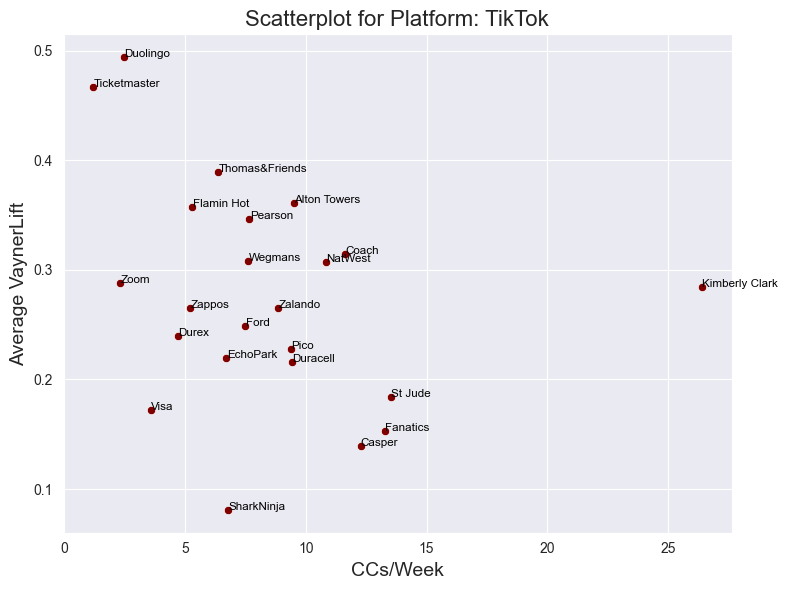

Data for Platform: Instagram


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17584,Casper,2022-06-30,15,Instagram,Cfbo3PFDGsi,Sleeping in my Casper is the only cure that wo...,Hangover Cure,https://www.instagram.com/reel/Cfbo3PFDGsi/,Cohort,"Work Hard, Play Hard, Sleep Harders",...,0,0,270,0,0,0.36,18,4,3.000000,2022-05-31
17585,Casper,2022-06-30,15,Instagram,CfboZWXDwAK,They’re gonna have to drag me out of here to g...,WFH Snooze,https://www.instagram.com/reel/CfboZWXDwAK/,Cohort,WFH to Stay In Bed Longer,...,0,0,1,0,0,0.00,75,2,1.829268,2022-05-31
17586,Casper,2022-06-30,15,Instagram,CfcEX2ZjPqv,Let’s see your cosiest blanket fort. #nostalgi...,No Fever,https://www.instagram.com/reel/CfcEX2ZjPqv/,Cohort,Extroverted About Being Introverts,...,0,0,239,0,0,0.33,70,4,1.707317,2022-05-31
17583,Casper,2022-07-01,17,Instagram,CfeWATTj80Y,Waiting for the next update 🍎 so I can get som...,Unsend,https://www.instagram.com/reel/CfeWATTj80Y/,Cohort,"Work Hard, Play Hard, Sleep Harders",...,0,0,0,0,0,0.00,18,4,3.000000,2022-05-31
17582,Casper,2022-07-01,13,Instagram,CfeIl9ljWxP,Good sleep can really bring you places #dream ...,Dream Land,https://www.instagram.com/reel/CfeIl9ljWxP/,Cohort,"Work Hard, Play Hard, Sleep Harders",...,0,0,2,0,0,0.00,18,4,3.000000,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3692255972.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


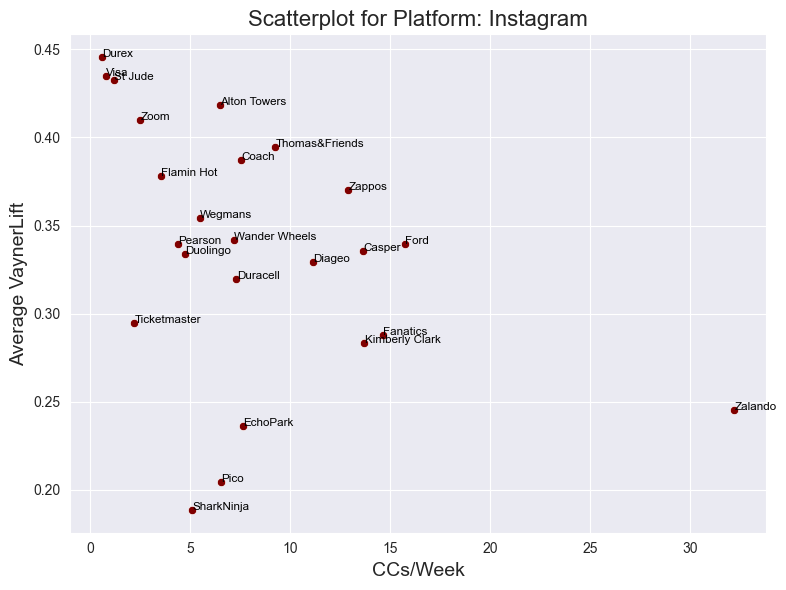

Data for Platform: Facebook


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17566,Casper,2022-07-11,14,Facebook,ehfOUjYkCk,Chill in the shade this season (with or withou...,Leafy Oasis,https://fb.watch/ehfOUjYkCk/,Cohort,Up at All Hours Vampire Workers,...,0,0,3,0,0,0.02,20,1,2.500000,2022-05-31
17561,Casper,2022-07-12,14,Facebook,2463184760524995,Drift into your summer of slumber with Casper.,Lazy River Oasis,https://www.facebook.com/Casper/photos/a.26261...,Cohort,InstaBragging Material Girls/Boys,...,0,0,2,0,0,0.07,85,1,2.236842,2022-05-31
17553,Casper,2022-07-13,14,Facebook,ehgPMD082G,Time to plug in and unplug,Charge,https://fb.watch/ehgPMD082G/,Cohort,Late Night Doom & Dopamine Scrollers,...,0,0,9,0,0,0.04,101,1,2.657895,2022-05-31
17552,Casper,2022-07-13,14,Facebook,ehgOEx2xn4,Find your away-from-the-crowd oasis this summe...,Desert Oasis,https://fb.watch/ehgOEx2xn4/,Cohort,Frequent Jet Setters Who Miss Their Bed,...,0,0,8,0,0,0.03,27,1,1.800000,2022-05-31
17551,Casper,2022-07-13,14,Facebook,2464104053766399,Sleep on it.,Vaca or Nap?,https://www.facebook.com/Casper/photos/a.26261...,Cohort,Frequent Jet Setters Who Miss Their Bed,...,0,0,8,0,0,0.66,27,1,1.800000,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3692255972.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


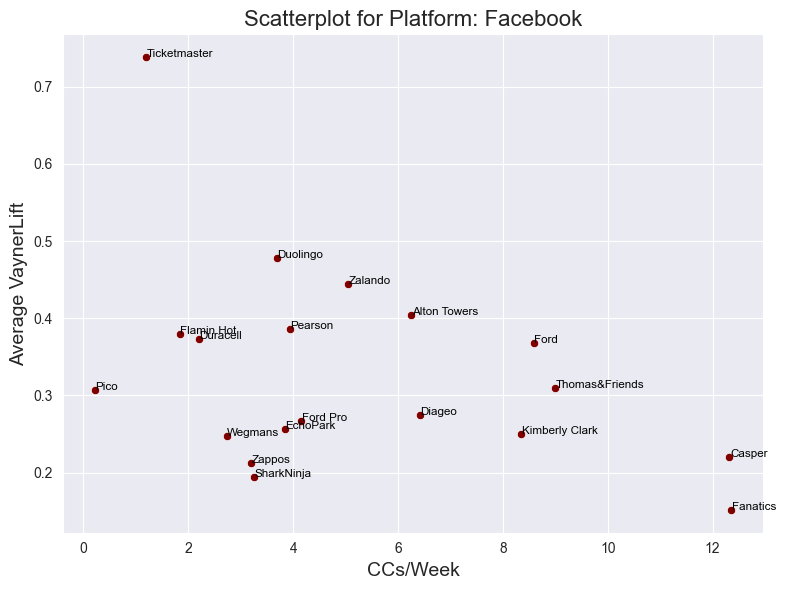

Data for Platform: YouTube


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17560,Casper,2022-07-13,14,YouTube,WMtY-0DgK-8,It’s really that simple.,New Hack,https://youtube.com/shorts/WMtY-0DgK-8?feature...,Cohort,There’s an App for That Modern Health Hackers,...,0,0,83,0,0,0.40,4,1,0.444444,2022-05-31
17558,Casper,2022-07-13,14,YouTube,Kb6jId5ghzc,Casper IS the moment #vibes,Comments in Auto Tune,https://youtube.com/shorts/Kb6jId5ghzc?feature...,Cohort,Late Night Doom & Dopamine Scrollers,...,0,0,15,0,0,0.26,101,1,2.657895,2022-05-31
17559,Casper,2022-07-13,14,YouTube,VvoSx4dofoA,We'll be here when you get back. #nosleep #tra...,Vaycay Sleep,https://youtube.com/shorts/VvoSx4dofoA?feature...,Cohort,Frequent Jet Setters Who Miss Their Bed,...,0,0,55,0,0,0.36,27,1,1.800000,2022-05-31
17532,Casper,2022-07-19,14,YouTube,8mBThsvBOzE,"Don't rely on a quick fix for a good sleep, ju...",Nightcap,https://youtube.com/shorts/8mBThsvBOzE?feature...,Cohort,Work Hard Play Hard Sleep Harders,...,0,0,44,0,0,0.18,35,1,2.692308,2022-05-31
17486,Casper,2022-07-28,14,YouTube,f9cGPFY_W2o,TT & Reels: Sound like a dream job come true? ...,Sleepers_TT_Announcement1,https://www.youtube.com/shorts/f9cGPFY_W2o,Cohort,Sleepers Bridge,...,0,0,19,0,0,0.29,166,1,8.736842,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3692255972.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


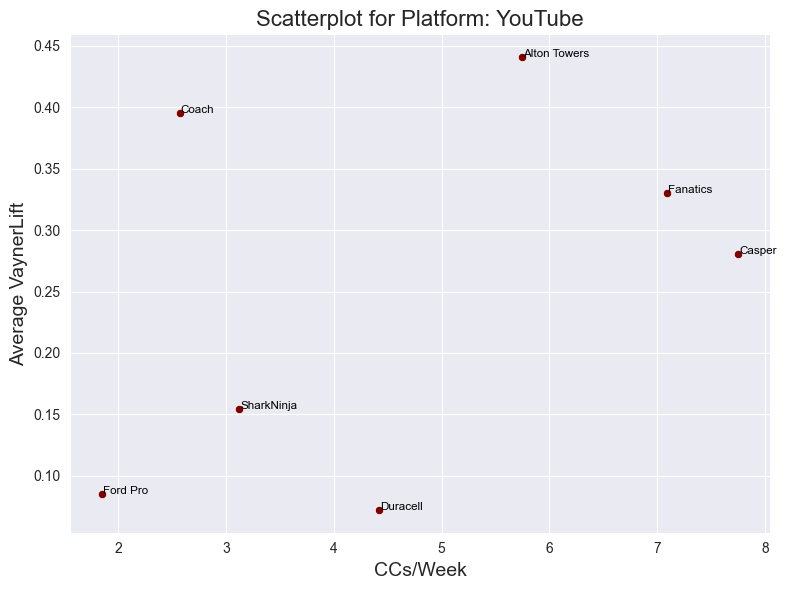

Data for Platform: Twitter


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17522,Casper,2022-07-22,14,Twitter,1550557083078213634,when the drink starts tasting like “pizza in b...,My drink starts tasting like,https://twitter.com/Casper/status/155055708307...,Cohort,Work Hard Play Hard Sleep Harders,...,0,0,1,0,0,0.05,35,1,2.692308,2022-05-31
17521,Casper,2022-07-23,13,Twitter,1550934592462340096,why is sleep the only skill where people say i...,Lazy Skill\n,https://twitter.com/Casper/status/155093459246...,Cohort,Work Hard Play Hard Sleep Harders,...,0,1,1,0,0,0.58,35,1,2.692308,2022-05-31
17519,Casper,2022-07-24,12,Twitter,1551373538606534656,whoever said “sleep was for the weak” was seri...,Sleep is NOT for the weak,https://twitter.com/Casper/status/155137353860...,Cohort,Work Hard Play Hard Sleep Harders,...,0,4,7,0,0,0.75,35,1,2.692308,2022-05-31
17514,Casper,2022-07-25,14,Twitter,1551568446839590913,make your bed every morning to distract from t...,"Bed Made, Life Messy",https://twitter.com/Casper/status/155156844683...,Cohort,Messy Hot Aunts Who Likes Their Bed Neat,...,0,0,4,0,0,0.05,15,1,1.250000,2022-05-31
17516,Casper,2022-07-25,14,Twitter,1551659113154691072,if you’ve ever looked at work and said “looks ...,All-Dayer\n,https://twitter.com/Casper/status/155165911315...,Cohort,Work Hard Play Hard Sleep Harders,...,0,0,2,0,0,0.05,35,1,2.692308,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3692255972.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


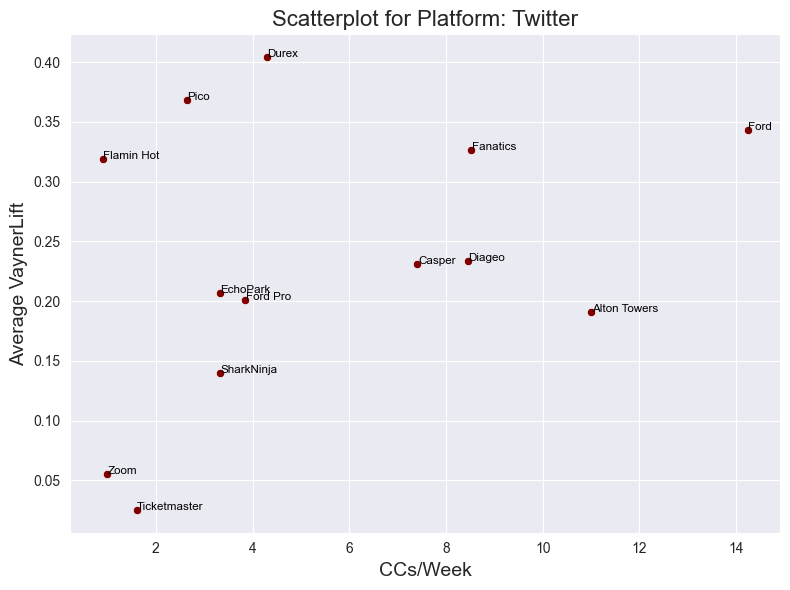

Data for Platform: Pinterest


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17492,Casper,2022-07-27,14,Pinterest,https://www.pinterest.com/pin/301600506306708424/,"Whether you make it first think or not at all,...",Bed making,https://www.pinterest.com/pin/301600506306708424/,Cohort,Messy Hot Aunts Who Likes Their Bed Neat,...,0,0,0,0,0,0.05,15,1,1.250000,2022-05-31
17488,Casper,2022-07-27,14,Pinterest,https://www.pinterest.com/pin/301600506306708223/,Headline: A mattress for new beginnings\nPost ...,"Updated, upgraded",https://www.pinterest.com/pin/301600506306708223/,Cohort,Couples and family Moving Up & In Together,...,0,0,0,0,0,0.05,51,1,4.250000,2022-05-31
17489,Casper,2022-07-27,14,Pinterest,https://www.pinterest.com/pin/301600506306708224/,The robes are good for pretty much everything ...,Casper Gear,https://www.pinterest.com/pin/301600506306708224/,Cohort,InstaBragging Material Girls/Boys,...,0,0,0,0,0,0.05,85,3,2.236842,2022-05-31
17490,Casper,2022-07-27,14,Pinterest,https://www.pinterest.com/pin/301600506306708421/,Headline: A bed you’ll never want to leave\nPo...,Night in is the new night out,https://www.pinterest.com/pin/301600506306708421/,Cohort,Couples and family Moving Up & In Together,...,0,0,0,0,0,0.03,51,1,4.250000,2022-05-31
17491,Casper,2022-07-27,14,Pinterest,https://www.pinterest.com/pin/301600506306708422/,Headline: Pillows for all your bedroom activit...,Up your pillow talk,https://www.pinterest.com/pin/301600506306708422/,Cohort,Couples and family Moving Up & In Together,...,0,0,0,0,0,0.05,51,1,4.250000,2022-05-31


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3692255972.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


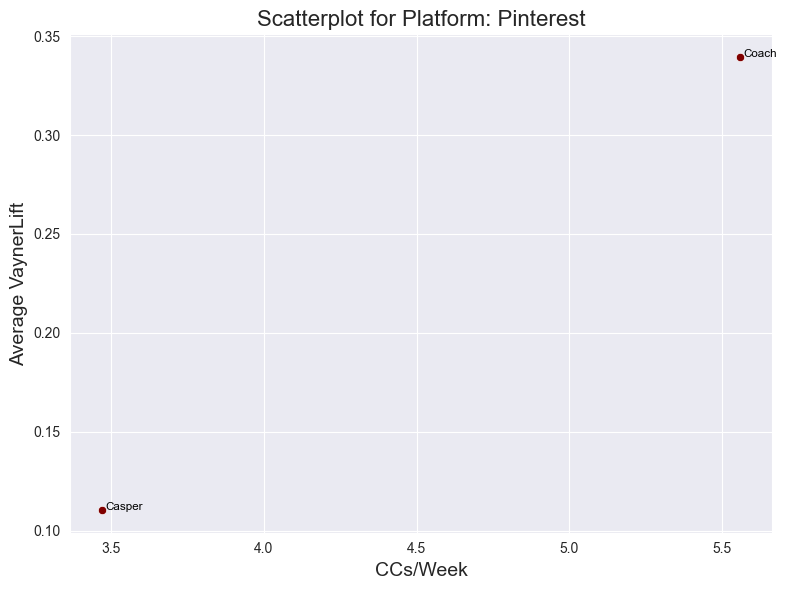

Data for Platform: LinkedIn


,Client,Post Date,days_on,platform,post_id,post_copy,ad_name,link,CohortCat,Cohort,...,replies,retweets,engagements,post_clicks,post_link_clicks,VaynerLift,Cohort Frequency,Weeks Since Start,CCs/Week,Start Date
17342,Ford Pro,2022-08-09,3,LinkedIn,https://www.linkedin.com/feed/update/urn:li:ac...,#FordPro is driving businesses forward with te...,Telematics Subcriptions,https://www.linkedin.com/feed/update/urn:li:ac...,Cohort,Investors,...,0,0,410,0,0,0.77,88,1,1.955556,2022-08-09
17056,Ford Pro,2022-08-30,1,LinkedIn,https://www.linkedin.com/feed/update/urn:li:ac...,"We’re moving beyond just trucks and vans, with...",Ted Quote,https://www.linkedin.com/feed/update/urn:li:ac...,Cohort,Investors,...,0,0,127,0,0,0.57,88,4,1.955556,2022-08-09
17035,Ford Pro,2022-08-31,10,LinkedIn,https://www.linkedin.com/feed/update/urn:li:ac...,#FordPro can help make your business more prod...,Wanda Quote,https://www.linkedin.com/feed/update/urn:li:ac...,Cohort,Investors,...,0,0,115,0,0,0.57,88,4,1.955556,2022-08-09
16898,Ford Pro,2022-09-08,12,LinkedIn,https://www.linkedin.com/feed/update/urn:li:ac...,This is Ford Pro™: leading execs,One-stop Video Series,https://www.linkedin.com/feed/update/urn:li:ac...,Cohort,Investors,...,0,0,99,0,0,0.43,88,5,1.955556,2022-08-09
16809,Ford Pro,2022-09-13,8,LinkedIn,https://www.linkedin.com/feed/update/urn:li:ac...,"Today, we're launching the Ford Pro™ Fleet Man...",Ford Pro™ Fleet Management solution launch,https://www.linkedin.com/feed/update/urn:li:ac...,Cohort,Fleet Managers,...,0,0,334,0,0,0.79,259,5,4.796296,2022-08-09


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/3692255972.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


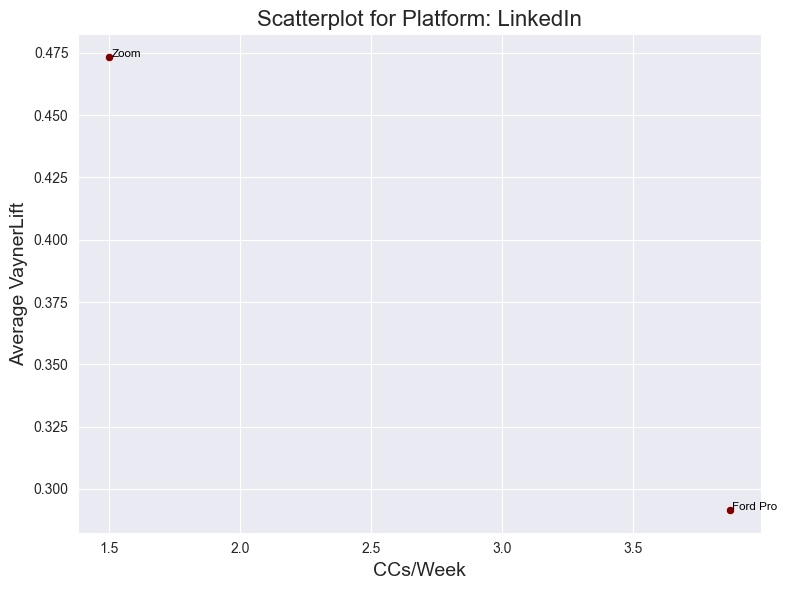

In [106]:
from IPython.display import display

# Loop through each unique platform
for platform in cohorts_df['platform'].unique():
    
    # Filter the dataframe by the current platform
    platform_df = cohorts_df[cohorts_df['platform'] == platform]
    
    # Display the filtered dataframe for the platform
    print(f"Data for Platform: {platform}")
    display(platform_df.head())  # Displays the top rows of the filtered dataframe; adjust to show more/less as needed
    
    # Follow the same analysis as before on the filtered data
    filtered_df = platform_df
    start_dates = filtered_df.groupby('Client')['Post Date'].min()
    filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)
    grouped_vaynerlift_means = filtered_df.groupby('Client').apply(agg_cc_freq).reset_index()
    grouped_vaynerlift_means.sort_values('median_vaynerlift', ascending=False).reset_index(drop=True)
    
    # Plot the scatterplot for the current platform
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='CCs/Week', y='avg_vaynerlift', data=grouped_vaynerlift_means, color='maroon')
    
    # Corrected Labeling
    for line in range(0, grouped_vaynerlift_means.shape[0]):
        plt.text(grouped_vaynerlift_means['CCs/Week'][line] + 0.01, 
                 grouped_vaynerlift_means.avg_vaynerlift[line], 
                 grouped_vaynerlift_means.Client[line], 
                 horizontalalignment='left', 
                 size='small', 
                 color='black')
    
    # Provide title and labels for clarity
    plt.title(f"Scatterplot for Platform: {platform}", fontsize=16)
    plt.xlabel('CCs/Week', fontsize=14)
    plt.ylabel('Average VaynerLift', fontsize=14)
    
    # Display the scatterplot
    plt.tight_layout()
    plt.show()
from IPython.display import display

# Loop through each unique platform
for platform in cohorts_df['platform'].unique():
    
    # Filter the dataframe by the current platform
    platform_df = cohorts_df[cohorts_df['platform'] == platform]
    
    # Display the filtered dataframe for the platform
    print(f"Data for Platform: {platform}")
    display(platform_df.head())  # Displays the top rows of the filtered dataframe; adjust to show more/less as needed
    
    # Follow the same analysis as before on the filtered data
    filtered_df = platform_df
    start_dates = filtered_df.groupby('Client')['Post Date'].min()
    filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)
    grouped_vaynerlift_means = filtered_df.groupby('Client').apply(agg_cc_freq).reset_index()
    grouped_vaynerlift_means.sort_values('median_vaynerlift', ascending=False).reset_index(drop=True)
    
    # Plot the scatterplot for the current platform
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='CCs/Week', y='avg_vaynerlift', data=grouped_vaynerlift_means, color='maroon')
    
    # Corrected Labeling
    for line in range(0, grouped_vaynerlift_means.shape[0]):
        plt.text(grouped_vaynerlift_means['CCs/Week'][line] + 0.01, 
                 grouped_vaynerlift_means.avg_vaynerlift[line], 
                 grouped_vaynerlift_means.Client[line], 
                 horizontalalignment='left', 
                 size='small', 
                 color='black')
    
    # Provide title and labels for clarity
    plt.title(f"Scatterplot for Platform: {platform}", fontsize=16)
    plt.xlabel('CCs/Week', fontsize=14)
    plt.ylabel('Average VaynerLift', fontsize=14)
    
    # Display the scatterplot
    plt.tight_layout()
    plt.show()


Scatterplot for Platform: TikTok


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1907767495.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


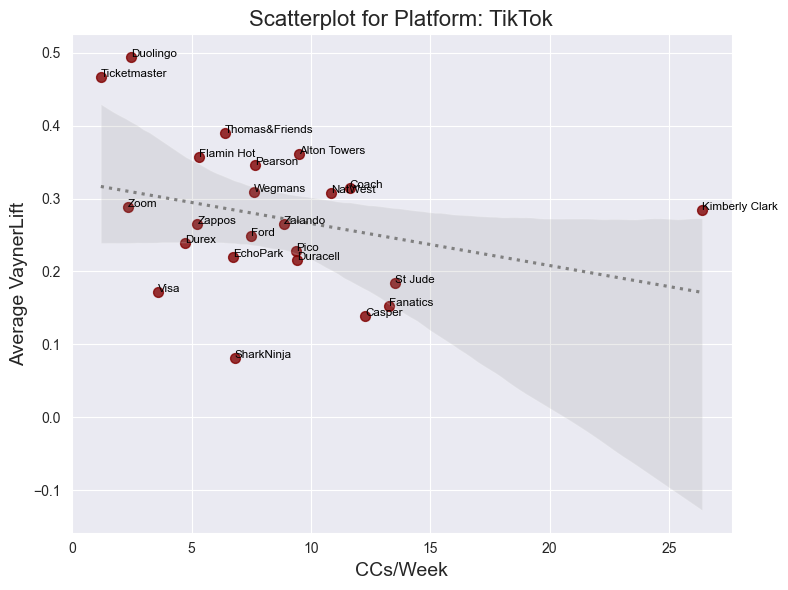

Scatterplot for Platform: Instagram


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1907767495.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


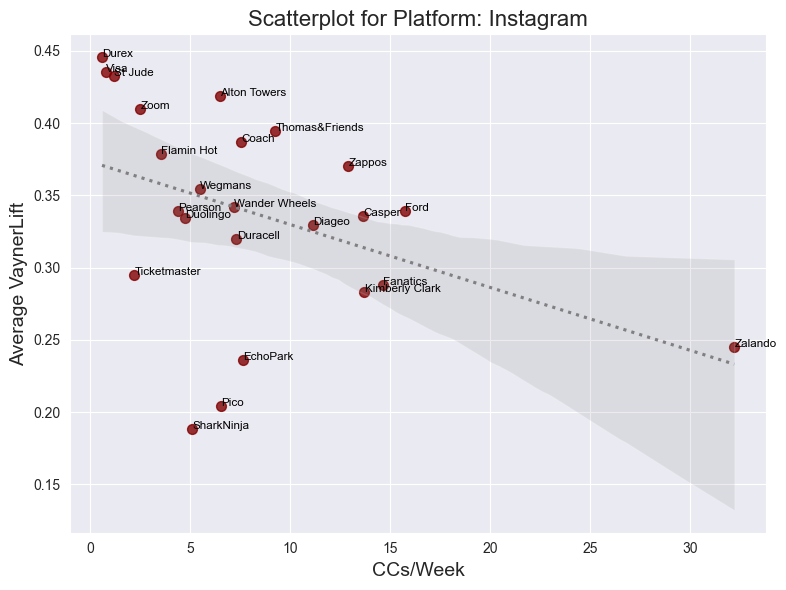

Scatterplot for Platform: Facebook


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1907767495.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


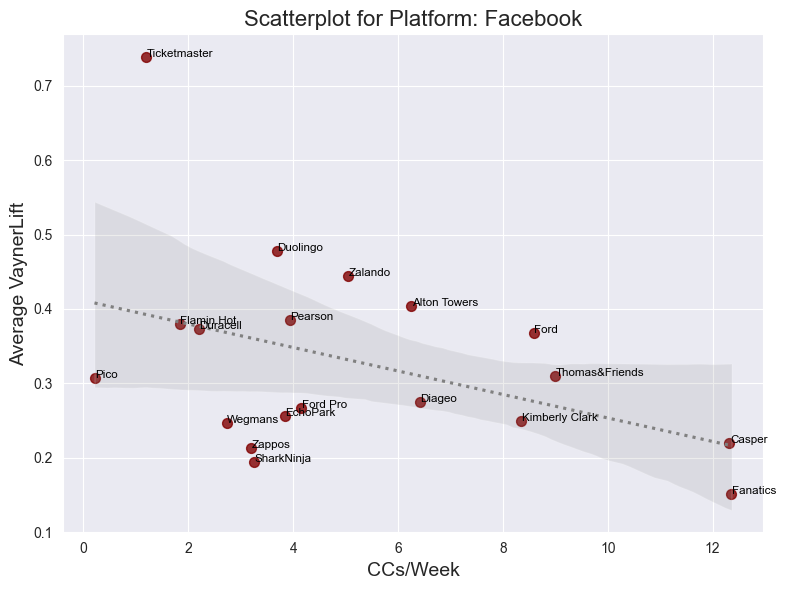

Scatterplot for Platform: YouTube


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1907767495.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


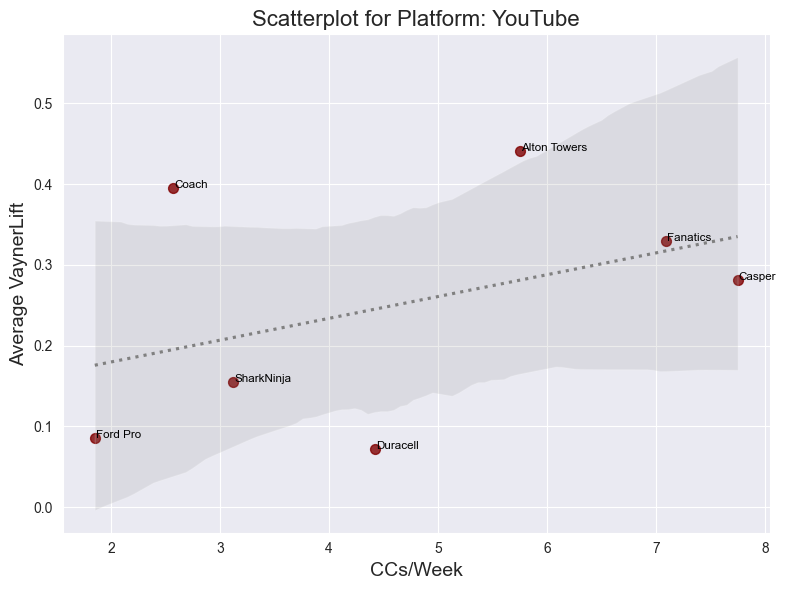

Scatterplot for Platform: Twitter


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1907767495.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


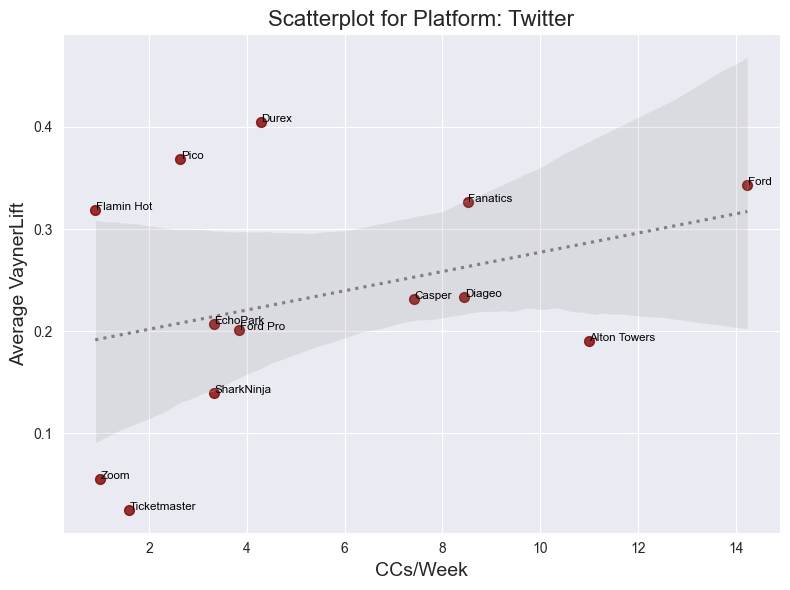

Scatterplot for Platform: Pinterest


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1907767495.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


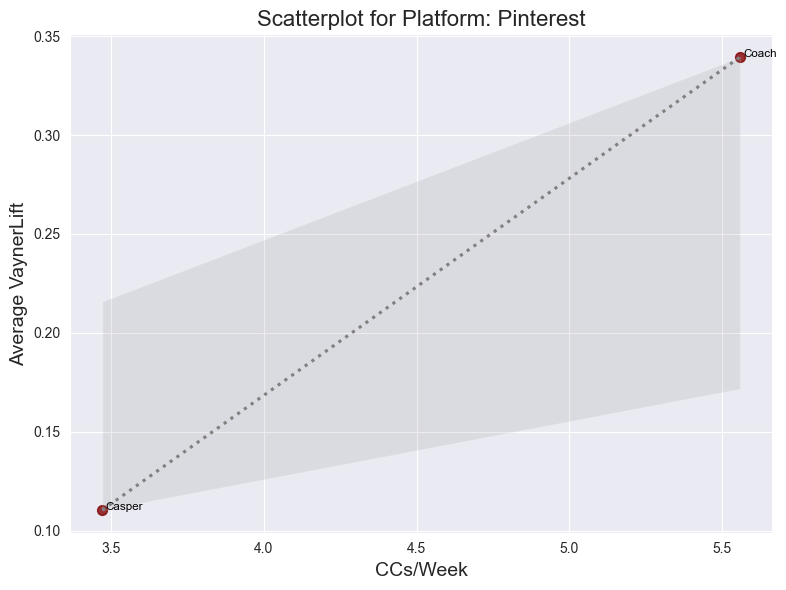

Scatterplot for Platform: LinkedIn


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_22214/1907767495.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)


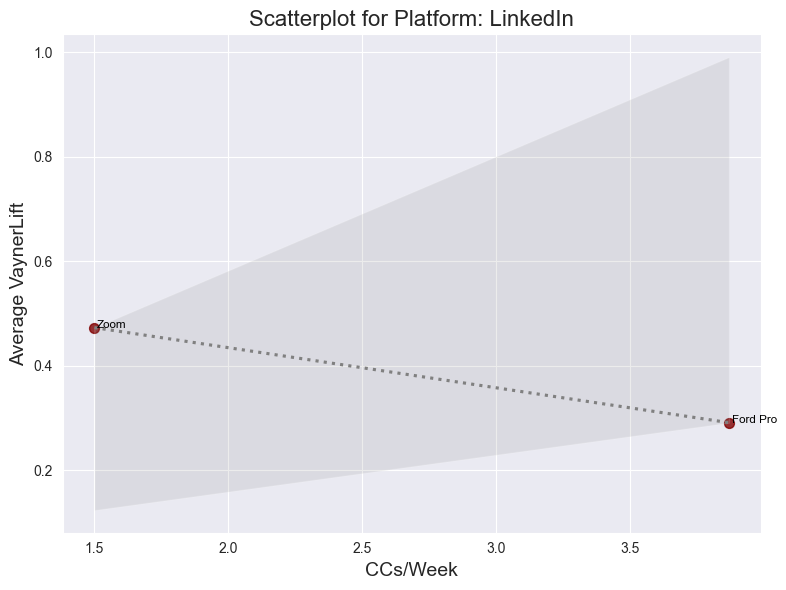

In [107]:
# Loop through each unique platform
for platform in cohorts_df['platform'].unique():
    
    # Filter the dataframe by the current platform
    platform_df = cohorts_df[cohorts_df['platform'] == platform]
    
    # Print the platform name
    print(f"Scatterplot for Platform: {platform}")
    
    # Follow the same analysis as before on the filtered data
    filtered_df = platform_df
    start_dates = filtered_df.groupby('Client')['Post Date'].min()
    filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)
    grouped_vaynerlift_means = filtered_df.groupby('Client').apply(agg_cc_freq).reset_index()
    
    # Plot the scatterplot for the current platform
    plt.figure(figsize=(8, 6))
    
    # Scatter plot with regression line
    sns.regplot(x='CCs/Week', y='avg_vaynerlift', data=grouped_vaynerlift_means, color='maroon', scatter_kws={'s':50}, line_kws={'color':'gray','linestyle':'dotted'})
    
    # Corrected Labeling
    for line in range(0, grouped_vaynerlift_means.shape[0]):
        plt.text(grouped_vaynerlift_means['CCs/Week'][line] + 0.01, 
                 grouped_vaynerlift_means.avg_vaynerlift[line], 
                 grouped_vaynerlift_means.Client[line], 
                 horizontalalignment='left', 
                 size='small', 
                 color='black')
    
    # Provide title and labels for clarity
    plt.title(f"Scatterplot for Platform: {platform}", fontsize=16)
    plt.xlabel('CCs/Week', fontsize=14)
    plt.ylabel('Average VaynerLift', fontsize=14)
    
    # Display the scatterplot
    plt.tight_layout()
    plt.show()
